In [120]:
%store -r df
%store -r EA_df
%store -r X_1
%store -r EA_vol_df_garch
%store -r EA_vol_df_std
%store -r EA_10Y_mth_yields
%store -r HICP__
%store -r GDP__

In [121]:
data = df
EA_data = data['EA_10Y']

In [122]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import scipy.stats as ss

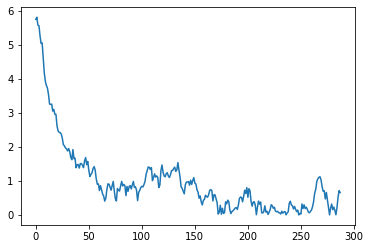

In [123]:
N = 12 * 24  # time steps
paths = 10  # number of paths
dt = 1/12

kappa = .5
theta = .5
sigma = .5

X0 = EA_data[0]
X = np.zeros((N, paths))
X[0, :] = X0
W = ss.norm.rvs(loc=0, scale=np.sqrt(dt), size=(N - 1, paths))

for t in range(0, N - 1):
    X[t + 1, :] = np.abs(X[t, :] + kappa * (theta - X[t, :]) * dt + sigma * W[t, :])

X_T = X[-1, :]  # values of X at time T
X_1 = X[:, 0]  # a single path
plt.plot(X_1)
plt.show()


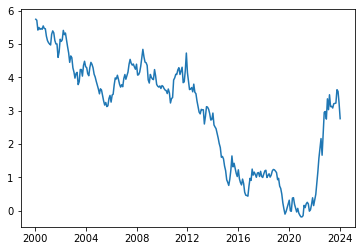

In [124]:
EA_data_match = EA_data[0:len(X_1)]
plt.plot(EA_data_match)
plt.show()

In [125]:
EA_df_ = pd.DataFrame(EA_data_match)
EA_df_.index.name=None

EA_vol_df_garch = EA_vol_df_garch[0:len(X_1)]
EA_vol_df_garch.set_index('Date', inplace=True)
EA_vol_df_garch.index = pd.to_datetime(EA_vol_df_garch.index)

EA_vol_df_std = EA_vol_df_std[0:len(X_1)]
EA_vol_df_std.set_index('Date', inplace=True)
EA_vol_df_std.index = pd.to_datetime(EA_vol_df_std.index)

In [126]:
yield_and_vols = pd.concat([EA_df_, EA_vol_df_garch], axis=1)
yield_and_vols

,EA_10Y,GARCH Volatility
2000-01-31,5.750700,0.000528
2000-02-29,5.719000,0.000649
2000-03-31,5.424600,0.000432
2000-04-30,5.503800,0.000991
2000-05-31,5.445600,0.001309
...,...,...
2023-08-31,3.229980,0.000333
2023-09-30,3.632590,0.003813
2023-10-31,3.581996,0.000932
2023-11-30,3.230450,0.001900


In [127]:
HICP = HICP__
GDP = GDP__


In [128]:
print(np.var(EA_data_match), np.cov(EA_data_match))

2.787172979998198 2.796884384109691


In [129]:
ds = np.array(X_1)

# Estimating the OU parameters
from ouparams import ouparams
mu, sigma, theta = ouparams.find(ds)
print(mu, sigma, theta)

0.5919407006855524 0.145407085140385 0.04592930661167805


In [130]:
# # Extract observations
# Y = EA_data_match.values

# # Kalman filter initialization
# kf = KalmanFilter(transition_matrices=[1],
#                   observation_matrices=[1],
#                   initial_state_mean=Y[0],
#                   initial_state_covariance=1,
#                   observation_covariance=1,
#                   transition_covariance=1)

# # Log likelihood function
# def log_likelihood(params):
#     kappa, theta, sigma, R = params
#     F = 1 - kappa * dt
#     B = sigma * np.sqrt(dt)
#     kf.transition_matrices = [F]
#     kf.transition_covariance = [[B**2]]
#     kf.observation_matrices = [1]
#     kf.observation_covariance = [[R]]
    
#     state_means, state_covariances = kf.filter(Y)
#     ll = kf.loglikelihood(Y)
#     return -ll  # minimize the negative log likelihood

# # Initial guesses for the parameters
# initial_params = [0.5, 0.5, 1.0, 0.1]

# # Optimize the parameters
# result = minimize(log_likelihood, initial_params, bounds=[(0, None), (None, None), (0, None), (0, None)])
# kappa_est, theta_est, sigma_est, R_est = result.x

# # Print the estimated parameters
# print(f"Estimated kappa: {kappa_est}")
# print(f"Estimated theta: {theta_est}")
# print(f"Estimated sigma: {sigma_est}")
# print(f"Estimated measurement noise R: {R_est}")

# # Filter the data using the estimated parameters
# F_est = 1 - kappa_est * dt
# B_est = sigma_est * np.sqrt(dt)
# kf.transition_matrices = [F_est]
# kf.transition_covariance = [[B_est**2]]
# kf.observation_matrices = [1]
# kf.observation_covariance = [[R_est]]

# state_means, state_covariances = kf.filter(Y)

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(Y, label='Observations')
# plt.plot(state_means, label='Filtered State', linestyle='dashed')
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('10Y Bond Yield')
# plt.title('Kalman Filter for CIR Model')
# plt.show()


In [131]:
# X0_new = EA_data[0]
# npaths = 1000  # number of paths
# X_new = np.zeros((N, npaths))
# X_new[0, :] = X0_new
# W_new = ss.norm.rvs(loc=0, scale=np.sqrt(dt), size=(N - 1, npaths))

# for t in range(0, N - 1):
#     X_new[t + 1, :] = np.abs(X_new[t, :] + kappa_est * (theta_est - X_new[t, :]) * dt + sigma_est * np.sqrt(X_new[t, :]) * W_new[t, :])

# X_T_new = X_new[-1, :]  # values of X at time T
# X_1_new = X_new[:, 0]  # a single path
# plt.plot(X_1_new)
# plt.show()
# plt.plot(X_new)
# plt.show()

Estimated kappa: 0.06290442469721208
Estimated theta: 0.5919407006855524
Estimated sigma: 0.5611123466482315


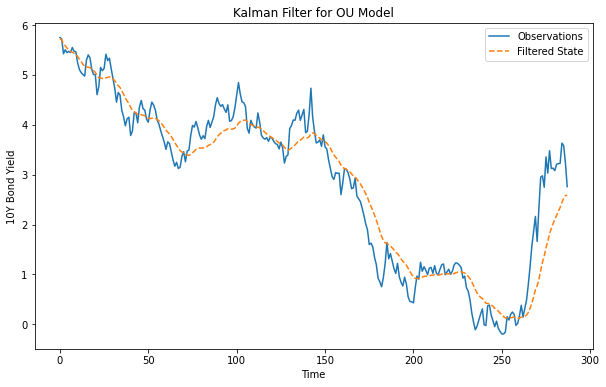

In [132]:
from filterpy.kalman import KalmanFilter

# Extract observations
Y = EA_data_match.values
#Y = X_1

# Initialize Kalman Filter
kf = KalmanFilter(dim_x=1, dim_z=1)
kf.x = np.array([Y[0]])  # initial state
kf.P = np.array([[1]])  # initial state covariance
kf.F = np.array([[np.exp(-kappa*dt)]])  # state transition matrix (to be updated)
kf.H = np.array([[1]])  # observation matrix
kf.R = np.array([np.cov(EA_data_match)])  # observation covariance (to be updated)
kf.Q = np.array([[sigma**2 * dt]])  # process covariance (to be updated)

# Log likelihood function
def log_likelihood(params):
    kappa, theta, sigma = params
    F = np.array([[np.exp(-kappa*dt)]])
    Q = np.array([[sigma**2 * dt]])
    H = np.array([[1]])
    R = np.array([np.cov(EA_data_match)])
    kf.F = F
    kf.Q = Q
    kf.R = R
    kf.H = H

    kf.x = np.array([Y[0]])  # reset initial state
    kf.P = np.array([[1]])   # reset initial covariance

    log_likelihood = 0
    for y in Y:
        try:
            kf.predict()
            kf.update(y)
            log_likelihood += kf.log_likelihood
        except np.linalg.LinAlgError:
            return np.inf  # return a large number to indicate failure

    return -log_likelihood  # minimize the negative log likelihood

# Initial guesses for the parameters
initial_params = [0.5, mu, 1.0]

# Optimize the parameters
result = minimize(log_likelihood, initial_params)
kappa_est, theta_est, sigma_est = result.x

# Print the estimated parameters
print(f"Estimated kappa: {kappa_est}")
print(f"Estimated theta: {theta_est}")
print(f"Estimated sigma: {sigma_est}")

# Filter the data using the estimated parameters
kf.F = np.array([[1 - kappa_est * dt]])
kf.Q = np.array([[sigma_est**2 * dt]])

state_means, state_covariances = [], []
kf.x = np.array([Y[0]])  # reset initial state
kf.P = np.array([[1]])   # reset initial covariance

for y in Y:
    kf.predict()
    kf.update(y)
    state_means.append(kf.x[0])
    state_covariances.append(kf.P[0, 0])

state_means = np.array(state_means)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(Y, label='Observations')
plt.plot(state_means, label='Filtered State', linestyle='dashed')
plt.legend()
plt.xlabel('Time')
plt.ylabel('10Y Bond Yield')
plt.title('Kalman Filter for OU Model')
plt.show()


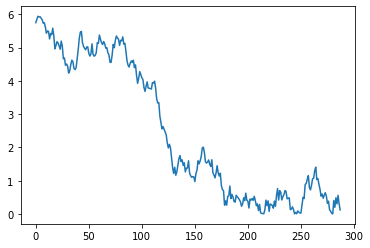

In [133]:
X0_new = EA_data[0]
npaths = 100  # number of paths
X_new = np.zeros((N, npaths))
X_new[0, :] = X0_new
W_new = ss.norm.rvs(loc=0, scale=np.sqrt(dt), size=(N - 1, npaths))

for t in range(0, N - 1):
    X_new[t + 1, :] = np.abs(X_new[t, :] + kappa_est * (theta_est - X_new[t, :]) * dt + sigma_est * W_new[t, :])

X_T_new = X_new[-1, :]  # values of X at time T
X_1_new = X_new[:, 0]  # a single path
plt.plot(X_1_new)
plt.show()
# plt.plot(X_new)
# plt.show()

Text(0.5, 1.0, 'Real Data Overlaying Simulated OU Paths with Kalman Estimated Parameters')

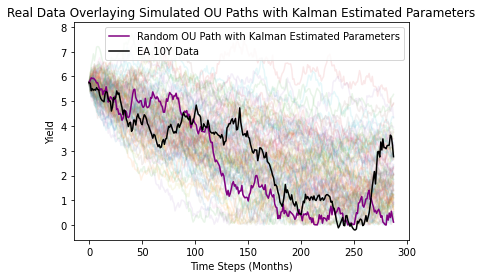

In [134]:
plt.plot(X_new, alpha=.1)
plt.plot(X_1_new, color='purple', label = 'Random OU Path with Kalman Estimated Parameters')
plt.plot(EA_data_match.values, color='black', label = 'EA 10Y Data')
plt.legend()
plt.xlabel('Time Steps (Months)')
plt.ylabel('Yield')
plt.title('Real Data Overlaying Simulated OU Paths with Kalman Estimated Parameters')

Estimated kappa: 0.06395999724067171
Estimated theta: 0.5919407006855524
Estimated sigma: 0.5662196929439772


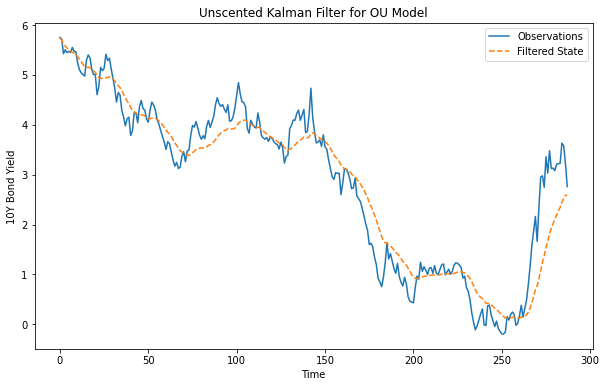

In [135]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

# Observation data
# Extract observations
Y = EA_data_match.values
#Y = X_1

# Time step (monthly)
dt = 1 / 12

# State transition function
def fx(x, dt, kappa):
    C = theta * (1 - np.exp(-kappa * dt))
    F = np.array([[np.exp(-kappa*dt)]])
    return C + np.dot(F, x)

# Measurement function
def hx(x):
    return np.array([x[0]])

# Initialize UKF
points = MerweScaledSigmaPoints(n=1, alpha=0.1, beta=2.0, kappa=0)
ukf = UKF(dim_x=1, dim_z=1, fx=fx, hx=hx, dt=dt, points=points)

# Log likelihood function
def log_likelihood(params):
    kappa, theta, sigma = params
    ukf.fx = lambda x, dt: fx(x, dt, kappa)
    ukf.R = np.array(np.var(EA_data_match))
    Q = sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt))
    ukf.Q = np.array([[Q]])

    ukf.x = np.array([Y[0]])  # reset initial state
    ukf.P = np.array([[1]])   # reset initial covariance

    log_likelihood = 0
    for y in Y:
        try:
            ukf.predict()
            ukf.update(np.array([y]))
            log_likelihood += ukf.log_likelihood
        except np.linalg.LinAlgError:
            return np.inf  # return a large number to indicate failure

    return -log_likelihood  # minimize the negative log likelihood

# Initial guesses for the parameters
initial_params = [0.5, mu , 1.0]

# Optimize the parameters
result = minimize(log_likelihood, initial_params)
kappa_est2, theta_est2, sigma_est2 = result.x

# Print the estimated parameters
print(f"Estimated kappa: {kappa_est2}")
print(f"Estimated theta: {theta_est2}")
print(f"Estimated sigma: {sigma_est2}")

# # Filter the data using the estimated parameters
ukf.fx = lambda x, dt: fx(x, dt, kappa_est2)
ukf.R = np.array(np.var(EA_data_match))
# Process noise covariance
Q = sigma_est2**2 / (2 * kappa_est2) * (1 - np.exp(-2 * kappa_est2 * dt))
ukf.Q = np.array([[Q]])

state_means2, state_covariances2 = [], []
ukf.x = np.array([Y[0]])  # reset initial state
ukf.P = np.array([[1]])   # reset initial covariance

for y in Y:
    ukf.predict()
    ukf.update(np.array([y]))
    state_means2.append(ukf.x[0])
    state_covariances2.append(ukf.P[0, 0])

state_means2 = np.array(state_means2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(Y, label='Observations')
plt.plot(state_means2, label='Filtered State', linestyle='dashed')
plt.legend()
plt.xlabel('Time')
plt.ylabel('10Y Bond Yield')
plt.title('Unscented Kalman Filter for OU Model')
plt.show()



Estimated kappa: 0.1148915335630523
Estimated theta: 1e-05
Estimated sigma: 0.08534401604872616


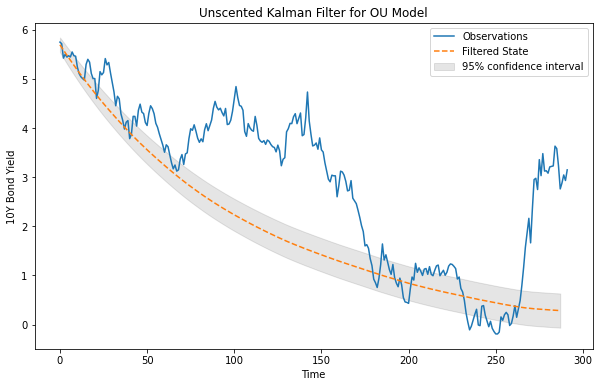

In [136]:
# State transition function for Vasicek model
def fx(x, dt, kappa, theta, sigma):
    F = np.exp(-kappa * dt)
    C = theta * (1 - F)
    return C + F * x

# Measurement function with a(tau) and b(tau)
def hx(x, a_tau, b_tau):
    return a_tau + b_tau * x

# Log likelihood function
def log_likelihood(params, observations, dt, x0, R_values):
    kappa, theta, sigma = params

    tau = 10
    Lambda = 0
    gamma = kappa**2 * (theta - sigma*Lambda/kappa) - sigma**2 / 2
    b_tau = (1 - np.exp(-kappa * dt)) / kappa
    a_tau = (b_tau - tau) * gamma / kappa**2 - ((sigma**2 * b_tau**2) / (4 * kappa))

    # Initialize UKF
    points = MerweScaledSigmaPoints(n=1, alpha=0.1, beta=2.0, kappa=0)
    ukf = UKF(dim_x=1, dim_z=1, dt=dt, hx=lambda x: hx(x, a_tau, b_tau), fx=lambda x, dt: fx(x, dt, kappa, theta, sigma), points=points)
    ukf.x = np.array([observations[0]])  # reset initial state

    # Process noise covariance
    Q = sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt))
    ukf.Q = np.array([[Q]])
    
    # Measurement noise covariance
    ukf.R = np.array(R_values) + np.eye(1) * 1e-4

    # Initial state and covariance
    ukf.P = np.array([sigma**2 / 2* kappa])  # Initial covariance    

    log_likelihood = 0

    for t in range(len(observations)):
        # Predict step
        try:
            ukf.predict()
        except np.linalg.LinAlgError as e:
            print(f"LinAlgError at step {t} during predict: {e}")
            break
        # Update step
        try:
            ukf.update(observations[t])
        except np.linalg.LinAlgError as e:
            print(f"LinAlgError at step {t} during update: {e}")
            break
        
        log_likelihood += ukf.log_likelihood

    return -log_likelihood  # minimize the negative log likelihood

# Initial guesses for the parameters
initial_params = [0.3, 0.1, 0.4]

# Observation data
Y = EA_data.values  # Ensure this is your observations data
x0 = EA_data.values[0]

R_values = np.var(EA_data.values)

# Time step (monthly)
dt = 1 / 12
N = 12 * 24

# Optimize the parameters
result = minimize(log_likelihood, initial_params, args=(Y, dt, x0, R_values), method='L-BFGS-B', bounds=[(1e-5, None), (1e-5, None), (1e-5, None)])
kappa_est2, theta_est2, sigma_est2 = result.x

# Print the estimated parameters
print(f"Estimated kappa: {kappa_est2}")
print(f"Estimated theta: {theta_est2}")
print(f"Estimated sigma: {sigma_est2}")

tau = 10
Lambda = 0
gamma2 = kappa_est2**2 * (theta_est2 - sigma_est2*Lambda/kappa_est2) - sigma_est2**2 / 2
b_tau = (1 - np.exp(-kappa_est2 * dt)) / kappa_est2
a_tau = (b_tau - tau) * gamma2 / kappa_est2**2 - ((sigma_est2**2 * b_tau**2) / (4 * kappa_est2))

# Filter the data using the estimated parameters
points = MerweScaledSigmaPoints(n=1, alpha=0.1, beta=2.0, kappa=0)
ukf = UKF(dim_x=1, dim_z=1, dt=dt, hx=lambda x: hx(x, a_tau, b_tau), fx=lambda x, dt: fx(x, dt, kappa_est2, theta_est2, sigma_est2), points=points)
# Initial state and covariance
ukf.x = np.array([Y[0]])  # reset initial state
ukf.P = np.array([sigma**2 / 2* kappa])  # Initial covariance

# Process noise covariance
Q = sigma_est2**2 / (2 * kappa_est2) * (1 - np.exp(-2 * kappa_est2 * dt))
ukf.Q = np.array([[Q]])

# Measurement noise covariance
ukf.R = np.array(R_values) + np.eye(1) * 1e-4

state_means2, state_covariances2 = np.zeros(N), np.zeros(N)

for t in range(N):
    # Predict step
    try:
        ukf.predict()
    except np.linalg.LinAlgError as e:
        print(f"LinAlgError at step {t} during predict: {e}")
        break
    # Update step
    try:
        ukf.update(Y[t])
    except np.linalg.LinAlgError as e:
        print(f"LinAlgError at step {t} during update: {e}")
        break

    state_means2[t] = ukf.x[0]
    state_covariances2[t] = ukf.P[0, 0]


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(Y, label='Observations')
plt.plot(state_means2, label='Filtered State', linestyle='dashed')
plt.fill_between(range(N), 
                 state_means2 - 1.96 * np.sqrt(state_covariances2),
                 state_means2 + 1.96 * np.sqrt(state_covariances2), 
                 color='k', alpha=0.1, label='95% confidence interval')
plt.legend()
plt.xlabel('Time')
plt.ylabel('10Y Bond Yield')
plt.title('Unscented Kalman Filter for OU Model')
plt.show()


In [137]:
# Print the estimated parameters
print(f"Estimated kappa: {kappa_est}")
print(f"Estimated theta: {theta_est}")
print(f"Estimated sigma: {sigma_est}")

# Print the estimated parameters
print(f"Estimated kappa2: {kappa_est2}")
print(f"Estimated theta2: {theta_est2}")
print(f"Estimated sigma2: {sigma_est2}")

Estimated kappa: 0.06290442469721208
Estimated theta: 0.5919407006855524
Estimated sigma: 0.5611123466482315
Estimated kappa2: 0.1148915335630523
Estimated theta2: 1e-05
Estimated sigma2: 0.08534401604872616


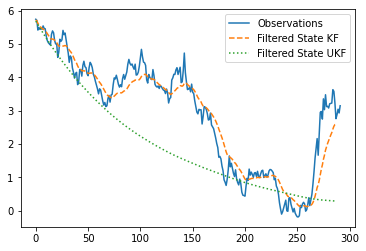

In [138]:
plt.plot(Y, label='Observations')
plt.plot(state_means, label='Filtered State KF', linestyle='dashed')
plt.plot(state_means2, label='Filtered State UKF', linestyle='dotted')
plt.legend()

# CIR Kalman

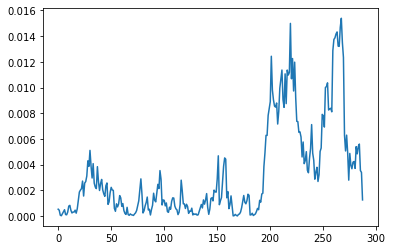

In [139]:
N = 12 * 24  # time steps
paths = 10  # number of paths
dt = 1/12

kappa = .2445
theta = .0038
sigma = .0635

X0 = EA_vol_df_garch['GARCH Volatility'][0]
X = np.zeros((N, paths))
X[0, :] = X0
W = ss.norm.rvs(loc=0, scale=np.sqrt(dt), size=(N - 1, paths))

for t in range(0, N - 1):
    X[t + 1, :] = np.abs(X[t, :] + kappa * (theta - X[t, :]) * dt + sigma * np.sqrt(X[t, :]) * W[t, :])

X_T = X[-1, :]  # values of X at time T
X_1 = X[:, 0]  # a single path
plt.plot(X_1)
plt.show()

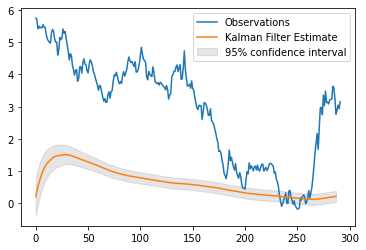

In [140]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

# Define Kalman Filter parameters
kf = KalmanFilter(dim_x=1, dim_z=1)

kf.F = np.array([[np.exp(-kappa * dt)]])  # State transition matrix
kf.H = np.array([[1]])               # Observation matrix
kf.Q = np.array([[theta * sigma**2 * (1 - np.exp(-kappa * dt))**2 / (2 * kappa) + sigma**2 / kappa * (np.exp(-kappa * dt) - np.exp(-2 * kappa * dt))]])   # Manually defined process noise covariance
kf.R = np.array([np.cov(EA_data_match)])             # Measurement noise covariance
kf.x = np.array([[X0]])              # Initial state
kf.P = np.eye(1) * 0.1               # Initial state covariance

# Applying the Kalman Filter
observations = EA_data.values  # using a single path as observations
filtered_state_means = np.zeros(N)
filtered_state_covariances = np.zeros(N)


for t in range(N):
    kf.predict()
    kf.update(observations[t])
    filtered_state_means[t] = kf.x[0]
    filtered_state_covariances[t] = kf.P[0, 0]

# Plot the results
plt.figure()
plt.plot(observations, label='Observations')
plt.plot(filtered_state_means, label='Kalman Filter Estimate')
plt.fill_between(range(N), 
                 filtered_state_means - 1.96 * np.sqrt(filtered_state_covariances),
                 filtered_state_means + 1.96 * np.sqrt(filtered_state_covariances), 
                 color='k', alpha=0.1, label='95% confidence interval')
plt.legend()
plt.show()

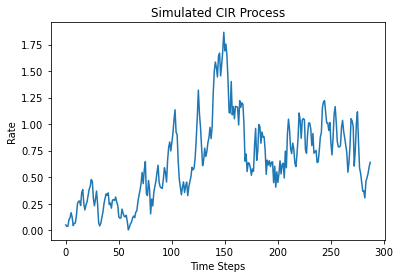

Estimated Parameters:
kappa: 0.010000000010012477
theta: 0.1
sigma: 0.04216346827599076
measurement variance: 1e-05


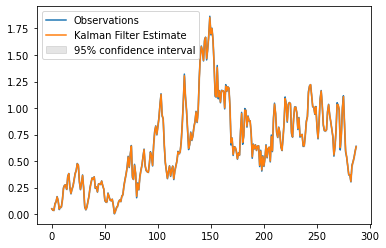

In [141]:
# Simulate CIR Process
def simulate_cir(kappa, theta, sigma, dt, X0, N):
    X = np.zeros(N)
    X[0] = X0
    W = ss.norm.rvs(loc=0, scale=np.sqrt(dt), size=N-1)
    
    for t in range(N-1):
        X[t+1] = np.abs(X[t] + kappa * (theta - X[t]) * dt + sigma * np.sqrt(X[t]) * W[t])
    
    return X

# Kalman Filter based log-likelihood for CIR model
def log_likelihood_cir(params, observations, dt):
    kappa, theta, sigma, measurement_var = params
    N = len(observations)
    
    # Initialize Kalman filter
    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.F = np.array([[1 - kappa * dt]])  # State transition matrix
    kf.H = np.array([[1]])               # Observation matrix
    kf.Q = np.array([[sigma**2 * dt]])   # Process noise covariance
    kf.R = np.array([[np.maximum(measurement_var, 1e-5)]]) # Measurement noise covariance, ensure positive
    kf.x = np.array([[observations[0]]]) # Initial state
    kf.P = np.eye(1) * 0.1               # Initial state covariance

    log_likelihood = 0

    for t in range(1, N):
        kf.predict()
        kf.update(observations[t])
        
        residual = observations[t] - kf.x[0]
        S = np.maximum(kf.S, 1e-5)  # Ensure variance is positive to avoid log(0)
        log_likelihood += -0.5 * (np.log(2 * np.pi * S) + (residual ** 2) / S)

    return -log_likelihood.item()  # Ensure the return value is a scalar

# Simulate data
N = 12 * 24  # time steps
dt = 1/12
kappa_true = 0.5
theta_true = 0.5
sigma_true = 0.5
X0 = 0.05  # Initial value of the state

observations = simulate_cir(kappa_true, theta_true, sigma_true, dt, X0, N)

# Plot the simulated data
plt.plot(observations)
plt.title("Simulated CIR Process")
plt.xlabel("Time Steps")
plt.ylabel("Rate")
plt.show()

# Initial parameter guesses
initial_params = [0.1, 0.1, 0.1, 0.1]

# Bounds for parameters to ensure they remain within realistic ranges
bounds = [(0.01, 2),  # kappa bounds
          (0.01, 2),  # theta bounds
          (0.01, 2),  # sigma bounds
          (1e-5, 1)]  # measurement variance bounds

# Minimize the negative log-likelihood with bounds
result = minimize(log_likelihood_cir, initial_params, args=(observations, dt), method='L-BFGS-B', bounds=bounds)
kappa_est, theta_est, sigma_est, measurement_var_est = result.x

print("Estimated Parameters:")
print(f"kappa: {kappa_est}")
print(f"theta: {theta_est}")
print(f"sigma: {sigma_est}")
print(f"measurement variance: {measurement_var_est}")

# Applying the Kalman Filter with estimated parameters
kf = KalmanFilter(dim_x=1, dim_z=1)
kf.F = np.array([[1 - kappa_est * dt]])  # State transition matrix
kf.H = np.array([[1]])                   # Observation matrix
kf.Q = np.array([[sigma_est**2 * dt]])   # Process noise covariance
kf.R = np.array([[measurement_var_est]]) # Measurement noise covariance
kf.x = np.array([[observations[0]]])     # Initial state
kf.P = np.eye(1) * 0.1                   # Initial state covariance

filtered_state_means = np.zeros(N)
filtered_state_covariances = np.zeros(N)

for t in range(N):
    kf.predict()
    kf.update(observations[t])
    filtered_state_means[t] = kf.x[0]
    filtered_state_covariances[t] = kf.P[0, 0]

# Plot the results
plt.figure()
plt.plot(observations, label='Observations')
plt.plot(filtered_state_means, label='Kalman Filter Estimate')
plt.fill_between(range(N), 
                 filtered_state_means - 1.96 * np.sqrt(filtered_state_covariances),
                 filtered_state_means + 1.96 * np.sqrt(filtered_state_covariances), 
                 color='k', alpha=0.1, label='95% confidence interval')
plt.legend()
plt.show()


In [142]:
# print(A_tau[-1])
# print(np.mean(B_tau[-1]))

In [143]:
EA_vol_df_garch['GARCH Volatility']

Date
2000-01-31    0.000528
2000-02-29    0.000649
2000-03-31    0.000432
2000-04-30    0.000991
2000-05-31    0.001309
                ...   
2023-08-31    0.000333
2023-09-30    0.003813
2023-10-31    0.000932
2023-11-30    0.001900
2023-12-31    0.003035
Name: GARCH Volatility, Length: 288, dtype: float64

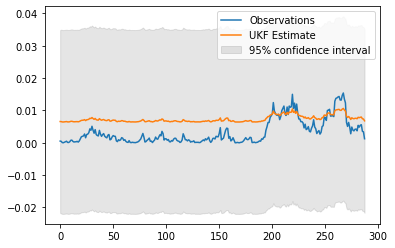

In [144]:
# Define state transition function for the CIR model
def fx(x, dt, kappa, theta, sigma):
    F = np.exp(-kappa * dt)
    C = theta * (1 - F)
    return C + F * x

# Define measurement function with a(tau) and b(tau)
def hx(x, a_tau, b_tau):
    return a_tau + b_tau * x

# Define process noise covariance function
def Q_matrix(x, dt, kappa, theta, sigma):
    term1 = theta * sigma**2 * (1 - np.exp(-kappa * dt))**2 / (2 * kappa)
    term2 = sigma**2 / kappa * (np.exp(-kappa * dt) - np.exp(-2 * kappa * dt)) * x
    return term1 + term2

# Define the parameters
kappa = .2445
theta = .0038
sigma = .0635
dt = 1/12

# Define initial state
x0 = X_1[0]  # initial value from your data

# Define the number of steps
N = 12 * 24

# Define the volatilities (measurement noise covariance)
R_values = np.var(X_1)  # Assuming R is a numpy array

# Simulate observations (for demonstration purposes, we use the same simulation method)
observations = X_1

# Define a_tau and b_tau correctly based on the CIR model
tau = 10
lambda_ = 0
Gamma = np.sqrt((kappa + lambda_)**2 + 2 * sigma**2)
b_tau = 2 * (np.exp(Gamma * tau) - 1) / ((Gamma + kappa + lambda_) * (np.exp(Gamma * tau) - 1) + 2 * Gamma)
a_tau = 2 * kappa * theta / (sigma**2) * np.log(2 * Gamma * np.exp((Gamma + kappa + lambda_) * tau / 2) / ((Gamma + kappa + lambda_) * (np.exp(Gamma * tau) - 1) + 2 * Gamma))

# Set up sigma points
points = MerweScaledSigmaPoints(n=1, alpha=0.1, beta=2., kappa=1.0)

# Initialize UKF
ukf = UKF(dim_x=1, dim_z=1, dt=dt, hx=lambda x: hx(x, a_tau, b_tau), fx=lambda x, dt: fx(x, dt, kappa, theta, sigma), points=points)
ukf.x = np.array([x0])
ukf.P = np.eye(1) * 0.1 + np.eye(1) * 1e-4  # Initial covariance with regularization
ukf.R = np.cov(X_1) + np.eye(1) * 1e-4  # Measurement noise covariance with regularization

# Ensure that the initial state covariance is positive definite
ukf.P = ukf.P + np.eye(ukf.P.shape[0]) * 1e-4

# Run the UKF
filtered_state_means = np.zeros(N)
filtered_state_covariances = np.zeros(N)

for t in range(N):
    Q = Q_matrix(ukf.x, dt, kappa, theta, sigma)
    ukf.Q = np.array([[Q.item()]]) + np.eye(1) * 1e-4  # Ensure Q is positive definite
    
    # Ensure that the process noise covariance is positive definite
    ukf.Q = ukf.Q + np.eye(ukf.Q.shape[0]) * 1e-4
    
    # Predict step
    try:
        ukf.predict()
    except np.linalg.LinAlgError as e:
        print(f"LinAlgError at step {t} during predict: {e}")
        break

    try:
        ukf.update(observations[t])
    except np.linalg.LinAlgError as e:
        print(f"LinAlgError at step {t} during update: {e}")
        break
    
    filtered_state_means[t] = ukf.x[0]
    filtered_state_covariances[t] = ukf.P[0, 0]

# Plot the results
plt.figure()
plt.plot(observations, label='Observations')
plt.plot(filtered_state_means, label='UKF Estimate')
plt.fill_between(range(N), 
                 filtered_state_means - 1.96 * np.sqrt(filtered_state_covariances),
                 filtered_state_means + 1.96 * np.sqrt(filtered_state_covariances), 
                 color='k', alpha=0.1, label='95% confidence interval')
plt.legend()
plt.show()

In [145]:
print(a_tau, b_tau)
# print(A_tau[-1], np.array([np.mean(B_tau[-1])]))

-0.023525677885085684 3.6592840689022053


Parameter Esimtation

Estimated Parameters:
kappa: 0.3004519808287256
theta: 0.15291251026117367
sigma: 0.6731590833451463


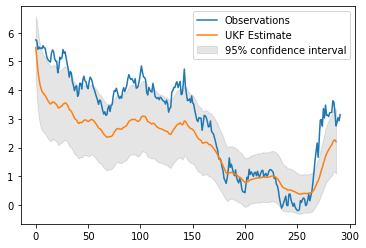

In [146]:
# Define state transition function for the CIR model
# Define state transition function for the CIR model
def fx(x, dt, kappa, theta, sigma):
    F = np.exp(-kappa * dt)
    C = theta * (1 - F)
    return C + F * x

# Define measurement function with a(tau) and b(tau)
def hx(x, a_tau, b_tau):
    return a_tau + b_tau * x

# Define process noise covariance function
def Q_matrix(x, dt, kappa, theta, sigma):
    term1 = theta * sigma**2 * (1 - np.exp(-kappa * dt))**2 / (2 * kappa)
    term2 = sigma**2 / kappa * (np.exp(-kappa * dt) - np.exp(-2 * kappa * dt)) * x
    return term1 + term2

# Define log-likelihood function
def log_likelihood(params, observations, dt, x0, R_values):
    kappa, theta, sigma = params
    
    tau = 10
    lambda_ = 0
    Gamma = np.sqrt((kappa + lambda_)**2 + 2 * sigma**2)
    b_tau = 2 * (np.exp(Gamma * tau) - 1) / ((Gamma + kappa + lambda_) * (np.exp(Gamma * tau) - 1) + 2 * Gamma)
    a_tau = 2 * kappa * theta / (sigma**2) * np.log(2 * Gamma * np.exp((Gamma + kappa + lambda_) * tau / 2) / ((Gamma + kappa + lambda_) * (np.exp(Gamma * tau) - 1) + 2 * Gamma))
    
    points = MerweScaledSigmaPoints(n=1, alpha=0.1, beta=2., kappa=1.0)
    ukf = UKF(dim_x=1, dim_z=1, dt=dt, hx=lambda x: hx(x, a_tau, b_tau), fx=lambda x, dt: fx(x, dt, kappa, theta, sigma), points=points)
    ukf.x = np.array([x0])
    ukf.P = np.array([[sigma**2 * theta / (2 * kappa)]])  # Initial covariance with regularization
    ukf.R = np.array([[R_values]]) + np.eye(1) * 1e-4  # Measurement noise covariance with regularization
    
    log_likelihood = 0

    for t in range(len(observations)):
        Q = Q_matrix(ukf.x, dt, kappa, theta, sigma)
        ukf.Q = np.array([[Q.item()]]) + np.eye(1) * 1e-4  # Ensure Q is positive definite
        
        # Ensure that the process noise covariance is positive definite
        ukf.Q = ukf.Q + np.eye(ukf.Q.shape[0]) * 1e-4
        
        # Predict step
        try:
            ukf.predict()
        except np.linalg.LinAlgError as e:
            print(f"LinAlgError at step {t} during predict: {e}")
            break
        # Update step
        try:
            ukf.update(observations[t])
        except np.linalg.LinAlgError as e:
            print(f"LinAlgError at step {t} during update: {e}")
            break
        
        log_likelihood += ukf.log_likelihood
    
    return -log_likelihood  # Return negative log-likelihood for minimization

# Define the parameters
initial_params = [0.3, 0.1, 0.6]

dt = 1/12

x0 = EA_data.values[0]  # initial value from your data

R_values = np.var(EA_data.values)  # Assuming R is a numpy array

# Simulate observations (for demonstration purposes, we use the same simulation method)
observations = EA_data.values

# Minimize the negative log-likelihood
result = minimize(log_likelihood, initial_params, args=(observations, dt, x0, R_values), method='L-BFGS-B', bounds=[(1e-5, None), (1e-5, None), (1e-5, None)])
kappa_est, theta_est, sigma_est = result.x

print("Estimated Parameters:")
print("kappa:", kappa_est)
print("theta:", theta_est)
print("sigma:", sigma_est)

# Run the UKF with the estimated parameters
kappa = kappa_est
theta = theta_est
sigma = sigma_est

tau = 10
lambda_ = 0
Gamma = np.sqrt((kappa + lambda_)**2 + 2 * sigma**2)
b_tau = (2 * (np.exp(Gamma * tau) - 1)) / ((Gamma + kappa + lambda_) * (np.exp(Gamma * tau) - 1) + 2 * Gamma)
a_tau = (2 * kappa * theta / (sigma**2)) * np.log((2 * Gamma * np.exp((Gamma + kappa + lambda_) * tau / 2)) / ((Gamma + kappa + lambda_) * (np.exp(Gamma * tau) - 1) + (2 * Gamma)))

points = MerweScaledSigmaPoints(n=1, alpha=0.1, beta=2., kappa=1.0)
ukf = UKF(dim_x=1, dim_z=1, dt=dt, hx=lambda x: hx(x, a_tau, b_tau), fx=lambda x, dt: fx(x, dt, kappa, theta, sigma), points=points)
ukf.x = np.array([x0])
ukf.P = np.array([[sigma**2 * theta / (2 * kappa)]])  # Initial covariance with regularization
ukf.R = np.array([[R_values]])  # Measurement noise covariance with regularization

filtered_state_means = np.zeros(N)
filtered_state_covariances = np.zeros(N)

# print(f"Initial state: {ukf.x}")
# print(f"Initial covariance: {ukf.P}")

for t in range(N):
    Q = Q_matrix(ukf.x, dt, kappa, theta, sigma)
    ukf.Q = np.array([[Q.item()]]) + np.eye(1) * 1e-4  # Ensure Q is positive definite
    
    # Ensure that the process noise covariance is positive definite
    ukf.Q = ukf.Q + np.eye(ukf.Q.shape[0]) * 1e-4
    
    # Predict step
    try:
        ukf.predict()
    except np.linalg.LinAlgError as e:
        print(f"LinAlgError at step {t} during predict: {e}")
        break
    # Update step
    try:
        ukf.update(observations[t])
    except np.linalg.LinAlgError as e:
        print(f"LinAlgError at step {t} during update: {e}")
        break
    
    filtered_state_means[t] = ukf.x[0]
    filtered_state_covariances[t] = ukf.P[0, 0]
    
    # print(f"Step {t}:")
    # print(f"Q_matrix: {ukf.Q}")
    # print(f"Filtered state mean: {ukf.x}")
    # print(f"Filtered state covariance: {ukf.P}")

# Plot the results
plt.figure()
plt.plot(observations, label='Observations')
plt.plot(filtered_state_means, label='UKF Estimate')
plt.fill_between(range(N), 
                 filtered_state_means - 1.96 * np.sqrt(filtered_state_covariances),
                 filtered_state_means + 1.96 * np.sqrt(filtered_state_covariances), 
                 color='k', alpha=0.1, label='95% confidence interval')
plt.legend()
plt.show()



In [147]:
a_tau, b_tau

(-0.6203095577308401, 1.539857398273715)

In [148]:
EA_vol_df_std

,Standard_Deviation
Date,
2000-01-31,0.000641
2000-02-29,0.000603
2000-03-31,0.000984
2000-04-30,0.000575
2000-05-31,0.000749
...,...
2023-08-31,0.000730
2023-09-30,0.001225
2023-10-31,0.000623


## Multidimensional

---

# Let's just try

___

In [149]:
%store -r level
%store -r slope

<ipython-input-150-42bef70c248e>:17: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(GDP.values/100))


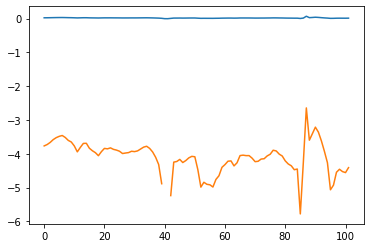

In [150]:
def symmetric_log_transform(x):
    if x >= 0:
        return np.log(x + 1)
    else:
        return -np.log(-x + 1)

# Example usage on a numpy array of GDP growth values
gdp_growth = GDP.values/100
hicp_temp = HICP.values/100
hicp_growth = np.log(hicp_temp)
# Apply the symmetric log transformation
symmetric_log_values = np.array([symmetric_log_transform(x) for x in gdp_growth])

##print("Original Values:", gdp_growth)
#print("Symmetric Log Transformed Values:", symmetric_log_values)
plt.plot(symmetric_log_values)
plt.plot(np.log(GDP.values/100))

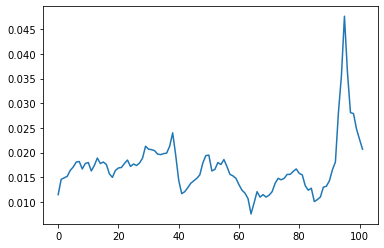

In [151]:
plt.plot(hicp_temp)
#plt.yscale('symlog')

In [189]:
# Example datasets
dates_yields = pd.date_range(start="2000-01-31", end="2024-04-30", freq='M')
EA_10Y_mth_yields__ = pd.Series(EA_10Y_mth_yields/100, index=dates_yields)

dates_vol = pd.date_range(start="2000-01-31", end="2023-12-31", freq='M')
#EA_vol_std__ = pd.Series(EA_vol_df_garch['GARCH Volatility'].values, index=dates_vol)
EA_vol_std__ = pd.Series(EA_vol_df_garch['GARCH Volatility'].values, index=dates_vol)

dates_hicp = pd.date_range(start="1999-12-31", end="2025-03-31", freq='Q')
HICP__ = pd.Series(hicp_temp, index=dates_hicp)

dates_gdp = pd.date_range(start="1999-01-01", end="2024-06-30", freq='Q')
GDP__ = pd.Series(symmetric_log_values, index=dates_gdp)

level = pd.Series(level, index=dates_yields)
slope = pd.Series(slope, index=dates_yields)

# Convert quarterly data to monthly by forward filling
HICP_monthly = HICP__.resample('M').interpolate(method='linear')
GDP_monthly = GDP__.resample('M').interpolate(method='linear')

# Find the common date range
common_start = max(EA_10Y_mth_yields__.index[0], EA_vol_std__.index[0], HICP_monthly.index[0], GDP_monthly.index[0])
common_end = min(EA_10Y_mth_yields__.index[-1], EA_vol_std__.index[-1], HICP_monthly.index[-1], GDP_monthly.index[-1])

# Truncate datasets to the common date range
EA_10Y_mth_yields__ = EA_10Y_mth_yields__.loc[common_start:common_end]
EA_vol_std__ = EA_vol_std__.loc[common_start:common_end]
HICP_monthly = HICP_monthly.loc[common_start:common_end]
GDP_monthly = GDP_monthly.loc[common_start:common_end]

# Combine all observations into a single array
avg_vol = np.mean(EA_vol_std__)

level = level.loc[common_start:common_end]
slope = slope.loc[common_start:common_end]

#observations = np.column_stack((EA_10Y_mth_yields__.values, EA_vol_std__.values, HICP_monthly.values, GDP_monthly.values))
observations = np.column_stack((EA_vol_std__.values, level.values, slope.values, HICP_monthly.values, GDP_monthly.values, EA_10Y_mth_yields__.values))

# Initial parameters
K_init = np.array([
    [0.2445, 0, 0, 0, 0], 
    [0.0823, 0.1356, 0.0789, -0.1207, -0.0257], 
    [0.0378, -0.0090, 0.3177, -0.1012, -0.1533], 
    [-0.0019, 0.0542, 0.0988, 0.4265, 0.0427], 
    [0.0088, 0.0312, 0.1609, 0.0332, 0.6246]
])
Theta_init = np.array([0.0038, 0, 0, 0.0214, 0.0257])
Sigma_init = np.array([
    [0.0635, 0, 0, 0, 0], 
    [0, 0.2373, 0, 0, 0], 
    [0, 0, 0.1226, 0, 0], 
    [0, 0, 0, 0.0101, 0], 
    [0, 0, 0, 0, 0.0099]
])
delta_0_init = 0.0296
delta_1_init = np.array([0, 1, 1, 0, 0])
lambda_0_init = np.array([-0.0515, -0.0278, 0.0325, 0.0001, 0.0002])
lambda_1_init = np.array([
    [0, 0, 0, 0, 0],
    [-0.0211, -0.3618, 0.0947, 0.3590, 0.0425],
    [-0.0047, -0.0494, -0.1315, 0.8385, 1.1479],
    [-0.0026, -0.0098, -0.0050, -0.0018, -0.0037],
    [-0.0008, -0.0027, -0.0013, -0.0049, -0.0007]
])

K_tilde = K_init + Sigma_init @ lambda_1_init
Theta_tilde = np.linalg.inv(K_tilde) @ (K_init @ Theta_init - Sigma_init @ lambda_0_init)

# Define Sigma_M from Table 3
Sigma_M_init = np.array([
    [0.0019, 0],
    [0, 0.0061]
])

alpha = np.array([0, 0, 0, 1, 1])
beta = np.array([
    [1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
])


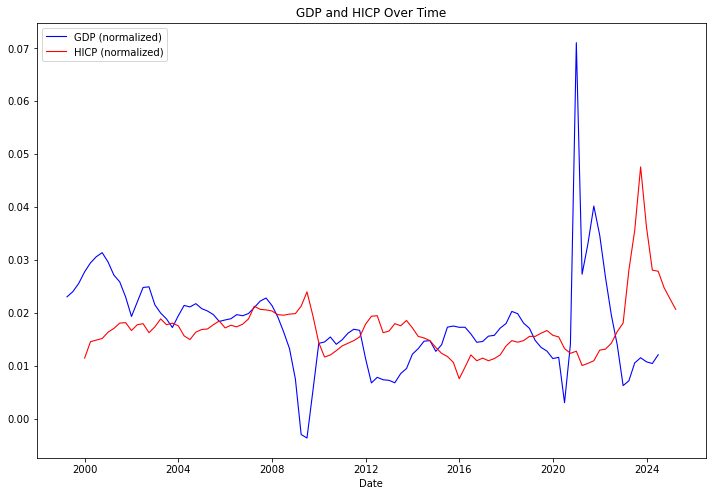

In [167]:
# Plotting the data with labels and title
plt.figure(figsize=(12, 8))

# Plotting GDP and HICP data
plt.plot(dates_gdp, GDP.values/100, label='GDP (normalized)', color='blue', linestyle='-', lw=1.1)
plt.plot(dates_hicp, HICP.values/100, label='HICP (normalized)', color='red', linestyle='-', lw=1.1)

# Adding labels and title
plt.xlabel('Date')
plt.title('GDP and HICP Over Time')
plt.legend()

In [33]:
import scipy
from scipy.integrate import solve_ivp
from scipy.linalg import cholesky

In [34]:
def ensure_positive_definite(matrix, jitter=1e-5):
    try:
        cholesky(matrix)
    except np.linalg.LinAlgError:
        matrix += np.eye(matrix.shape[0]) * jitter
        while True:
            try:
                cholesky(matrix)
                break
            except np.linalg.LinAlgError:
                matrix += np.eye(matrix.shape[0]) * jitter
                jitter *= 10  # Increase jitter exponentially if needed
    return matrix

In [35]:
var_vol = np.var(EA_vol_std__)

In [36]:
from joblib import Parallel, delayed
import torch

In [228]:
# # Global list to store unique measurements
# unique_measurements = []
# unique_transitions = []

# State transition function
def state_transition_function(x, dt, K, Theta, Sigma):
    #print(f"State transition function called with x={x}")
    # Debugging: Print input parameters
    # print(f"Input state x: {x}")
    #print(f"Time step dt: {dt}")
    #print(f"Matrix K: {K}")
    #print(f"Vector Theta: {Theta}")
    #print(f"Matrix Sigma: {Sigma}")
    F = scipy.linalg.expm(-K * dt)
    # print(f"State transition matrix F: {F}")
    C = (np.eye(len(F)) - F) @ Theta
    # print(f"Constant term C: {C}")
    epsilon_t = np.array([
        Theta[i] * Sigma[i, i]**2 / (2 * K[i, i]) * ((1 - np.exp(-K[i, i] * dt))**2) +
        Sigma[i, i]**2 / K[i, i] * ((np.exp(-K[i, i] * dt) - np.exp(-2 * K[i, i] * dt))**2) * x[0]
        for i in range(3)
    ] + [
        Sigma[i, i]**2 / (2 * K[i, i]) * (1 - np.exp(-2 * K[i, i] * dt))
        for i in range(3, 5)
    ])
    # e_t = np.random.normal(0, np.abs(epsilon_t))
    # transition = C + F @ x + e_t
    #print("Transition: ", transition)

    trans_dist = np.random.normal(C + F @ x, np.abs(epsilon_t))
    # eqn = x + K @ (Theta - x)*dt + e_t
    # if trans_dist.tolist() not in unique_transitions:
    #     unique_transitions.append(trans_dist.tolist())
    # print(f"Noise term epsilon_t: {epsilon_t}")
    # print("Transition Distribution: ", trans_dist)

    
    #print("State Equation: ", eqn)
    return trans_dist

# Measurement function
def measurement_function(x, A_tau, B_tau, observations, A_M, B_M, Sigma):
    #print(f"B_TAU going into measurement: {B_tau[-1]}, A_TAU {A_tau[-1]}")
    nu_t = np.random.normal(0, np.abs(np.var(EA_10Y_mth_yields__.values)))
    error_vol = np.random.normal(0, np.var(EA_vol_std__.values))
    GDP_var, HICP_var = np.var(GDP_monthly.values), np.var(HICP_monthly.values)
    error_GDP, error_HICP = np.random.normal(0, np.abs(GDP_var)), np.random.normal(0, np.abs(HICP_var))

    l_err = np.random.normal(0, np.abs(np.var(level.values)))  # Ensure this is a scalar
    s_err = np.random.normal(0, np.abs(np.var(slope.values)))

    # Ensure A_tau and B_tau are numpy arrays
    A_tau = np.array(A_tau)
    B_tau = np.array(B_tau)
    
    # print(f"A_tau: {A_tau}, B_tau: {B_tau}")  # Debugging print
    # print(f"A_tau type: {type(A_tau)}, B_tau type: {type(B_tau)}")  # Debugging print

    a_tau_ = -A_tau / 10
    b_tau_ = B_tau / 10

    # # Debugging information
    # #print(f"Measurement function called with x={x} and nu_t={nu_t}")
    # #print(f"A_M={A_M}, B_M={B_M}")

    # # Yields: linked to level and slope
    # # part1 = a_tau_[-1] + b_tau_[-1, 1] * x[1] + b_tau_[-1, 2] * x[2] + nu_t
    yields = a_tau_[-1] + np.dot(b_tau_[-1], x) + nu_t
    # ---------------------------------------------------------------------
    # # Ensure all elements are scalars or have compatible shapes
    part2 = a_tau_[-1] + np.dot(b_tau_[-1], x) + l_err
    part3 = a_tau_[-1] + np.dot(b_tau_[-1], x) + s_err
    
    Xi_t = np.diag([x[0], x[0], x[0], 1, 1])
    middle = np.dot(Sigma, np.dot(Xi_t, Sigma))
    # #V_t_tau = np.dot(np.dot(b_tau_[-1], Sigma), np.dot(Xi_t, np.dot(Sigma.T, b_tau_[-1])))
    V_t_ = np.dot(b_tau_[-1], np.dot(middle, b_tau_[-1]))
    part1 = V_t_ + error_vol
    # #print("V_t_tau: ", V_t_tau, "V_t_: ", V_t_)
    # # print("part2", part2)
    
    part4 = A_M[0] + np.dot(B_M[0], x) + error_HICP
    part5 = A_M[1] + np.dot(B_M[1], x) + error_GDP
    # ---------------------------------------------------------------------

    # print(f"part1: {part1}")
    # print(f"part2: {part2}")
    # print(f"part3: {part3}")
    # print(f"part4: {part4}")
    # # Debugging shapes and types
    # print(f"Shapes: part1={part1.shape if hasattr(part1, 'shape') else 'scalar'}, "
    #       f"part2={part2.shape if hasattr(part2, 'shape') else 'scalar'}, "
    #       f"part3={part3.shape if hasattr(part3, 'shape') else 'scalar'}, "
    #       f"part4={part4.shape if hasattr(part4, 'shape') else 'scalar'}")
    
    # Ensure all parts are compatible for array construction
    measurement = np.array([part1, x[1] + l_err, x[2] + s_err, part4, part5, yields], dtype='float64')

    # if measurement.tolist() not in unique_measurements:
    #     unique_measurements.append(measurement.tolist())
    #print("Measurement: ", measurement)

    # Debugging prints to inspect each part
    # print(f"x[0] + error_vol: {x[0] + error_vol}, shape: {np.shape(x[0] + error_vol)}")
    # print(f"x[1] + l_err: {x[1] + l_err}, shape: {np.shape(x[1] + l_err)}")
    # print(f"x[2] + s_err: {x[2] + s_err}, shape: {np.shape(x[2] + s_err)}")
    # print(f"x[3] + error_HICP: {x[3] + error_HICP}, shape: {np.shape(x[3] + error_HICP)}")
    # print(f"x[4] + error_GDP: {x[4] + error_GDP}, shape: {np.shape(x[4] + error_GDP)}")

    # Ensure the return value is a 1D array of shape (5,)
    result = np.array([
        x[0] + error_vol,
        x[1] + l_err,
        x[2] + s_err,
        x[3] + error_HICP,
        x[4] + error_GDP,
        yields
    ], dtype='float64')
    
    # Debugging print to confirm the shape of the final result
    #print(f"Final measurement array: {result}, shape: {result.shape}")
    
    #return result
    return result # Yields, Volatilities, GDP, HICP
    #return np.array([x[0] + nu_t, x[1] + error_vol, x[3] + error_GDP, x[4] + error_HICP])
    # return observations

# Define process noise covariance function
# Optimized Q Matrix Calculation
def Q_matrix_5D(x, dt, K, Theta, Sigma):
    Q_t = np.array([
        Theta[i] * Sigma[i, i]**2 / (2 * K[i, i]) * ((1 - np.exp(-K[i, i] * dt))**2) +
        Sigma[i, i]**2 / K[i, i] * ((np.exp(-K[i, i] * dt) - np.exp(-2 * K[i, i] * dt))**2) * x[0]
        for i in range(3)
    ] + [
        Sigma[i, i]**2 / (2 * K[i, i]) * (1 - np.exp(-2 * K[i, i] * dt))
        for i in range(3, 5)
    ])
    Q_matrix = np.diag(Q_t)
    jitter = 1e-5
    Q_matrix += np.eye(Q_matrix.shape[0]) * jitter
    return ensure_positive_definite(Q_matrix)

# Define ODE functions
def dA_dt(t, A, B, Theta_tilde, K_tilde, Sigma, alpha, delta_0):
    dA = -Theta_tilde.T @ K_tilde.T @ B + 0.5 * np.sum((Sigma.T @ B)**2 * alpha) - delta_0
    return dA

def dB_dt(t, B, K_tilde, Sigma, beta, delta_1):
    try:
        # Log input values
        # print(f"t: {t}")
        # print(f"B: {B}")
        # print(f"K_tilde: {K_tilde}")
        # print(f"Sigma: {Sigma}")
        # print(f"beta: {beta}")
        # print(f"delta_1: {delta_1}")

        # Calculate dB
        dB = -K_tilde.T @ B + 0.5 * np.sum((Sigma.T @ B)**2 * beta, axis=1) + delta_1

        # Log intermediate values
        #print(f"dB: {dB}")

        # Check for NaN or Inf values
        if np.any(np.isnan(dB)) or np.any(np.isinf(dB)):
            raise ValueError("NaN or Inf in dB calculation")
        return dB
    
    except FloatingPointError as e:
        print(f"FloatingPointError in dB_dt: {e}")
        return np.zeros_like(B)
    
    except ValueError as e:
        print(f"ValueError in dB_dt: {e}")
        return np.zeros_like(B)

# Solve ODEs for each maturity
def solve_odes(maturities, steps_per_year, K_tilde, Theta_tilde, Sigma, alpha, beta, delta_0, delta_1):
    A_tau, B_tau = [], []
    # Initial conditions for ODEs
    A0 = 0
    B0 = np.zeros(5)
    
    for tau in maturities:
        t_eval = np.linspace(0, tau, tau * steps_per_year)
        sol_B = solve_ivp(lambda t, B: dB_dt(t, B, K_tilde, Sigma, beta, delta_1), [0, tau], B0, t_eval=t_eval)
        sol_A = solve_ivp(lambda t, A: dA_dt(t, A, sol_B.y[:, -1], Theta_tilde, K_tilde, Sigma, alpha, delta_0), [0, tau], [A0], t_eval=t_eval)
        A_tau.append(sol_A.y[0][-1])
        B_tau.append(sol_B.y[:, -1])
        # Print shapes and intermediate results for debugging
        # print(f"tau: {tau}")
        # print(f"sol_A.y shape: {sol_A.y.shape}, sol_A.y: {sol_A.y}")
        # print(f"sol_B.y shape: {sol_B.y.shape}, sol_B.y: {sol_B.y}")
    A_tau = np.array(A_tau)
    B_tau = np.array(B_tau)
    # Print shapes of results
    # print(f"A_tau shape: {A_tau.shape}, A_tau: {A_tau}")
    # print(f"B_tau shape: {B_tau.shape}, B_tau: {B_tau}")
    #print(f"A_tau: {A_tau[-1]}")
    #print(f"B_tau: {B_tau[-1]}")
    return A_tau, B_tau

# Compute B_M(tau) and A_M(tau)
def compute_BM_AM(tau, K, Sigma_M, Theta):
    try:
        Gamma_M = np.array([
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 1]
        ])
        iota = np.array([1, 1])
        exp_term = scipy.linalg.expm(-K * tau)
        I = np.eye(K.shape[0])
        BM_tau = Gamma_M @ np.linalg.inv(K) @ (I - exp_term)
        AM_tau = (-0.5 * Sigma_M @ Sigma_M.T @ iota * tau) + ((tau * Gamma_M - BM_tau) @ Theta)
        #print("A_M: ", AM_tau, "B_M: ", BM_tau)

        if np.any(np.isnan(AM_tau)) or np.any(np.isnan(BM_tau)):
            raise ValueError("NaN in AM_tau or BM_tau calculation")
        
        return np.array(AM_tau, dtype='float64'), np.array(BM_tau, dtype='float64')
    
    except np.linalg.LinAlgError as e:
        print(f"LinAlgError in compute_BM_AM: {e}")
        return np.zeros((2,), dtype='float64'), np.zeros((2, 5), dtype='float64')
    
    except ValueError as e:
        print(f"ValueError in compute_BM_AM: {e}")
        return np.zeros((2,), dtype='float64'), np.zeros((2, 5), dtype='float64')



# Log-likelihood calculation with jitter for stability
def run_ukf(observations, K, Theta, Sigma, delta_0, lambda_0, lambda_1, X0, P0, R, dt, A_tau, B_tau, A_M, B_M):
    #print(f"B_TAU GOING INTO RUN UKF {B_tau}, A_TAU {A_tau}")
    points = MerweScaledSigmaPoints(n=5, alpha=0.2, beta=1.5, kappa=1)
    ukf = UKF(dim_x=5, dim_z=observations.shape[1], fx=lambda x, dt: state_transition_function(x, dt, K, Theta, Sigma),
              hx=lambda x: measurement_function(x, A_tau, B_tau, observations, A_M, B_M, Sigma), dt=dt, points=points)
    ukf.x = X0
    jitter = 1e-6
    ukf.P = ensure_positive_definite(P0 + np.eye(P0.shape[0]) * jitter)
    ukf.R = ensure_positive_definite(R)
    # ukf.Q = np.eye(5) * 0.001

    # print(f"Initial P0: {ukf.P}")  # Debugging print

    log_likelihood = 0
    for idx, z in enumerate(observations):
        Q = Q_matrix_5D(ukf.x, dt, K, Theta, Sigma)
        ukf.Q = ensure_positive_definite(Q + np.eye(Q.shape[0]) * jitter)

        # print(f"Q before jitter: {Q}")  # Debugging print
        # print(f"Q after jitter: {ukf.Q}")  # Debugging print

        #print(f"Observation {idx}: {z}")
        ukf.predict()
        try:
            ukf.update(z)
        except (np.linalg.LinAlgError, ValueError) as e:
            print(f"Error during UKF update: {e}")
            return np.inf
        log_likelihood += ukf.log_likelihood
        #S_stable = ukf.S + np.eye(ukf.S.shape[0]) * jitter
        #print(f"Log likelihood at observation {idx}: {log_likelihood}")

    return -log_likelihood

def check_for_invalid_values(arr, name):
    if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
        print(f"Invalid values detected in {name}: {arr}")
        return True
    return False

# Objective function for optimization
def objective_function(params, observations, X0, P0, R, dt, maturities, steps_per_year):
    # print("Objective function called")
    K = params[:25].reshape((5, 5))
    #K[0,1], K[0,2], K[0,3], K[0,4] = 0, 0, 0, 0
    Theta = params[25:30]
    #Theta[1], Theta[2] = 0, 0
    Sigma = np.diag(params[30:35])
    delta_0 = params[35]
    lambda_0 = params[36:41]
    lambda_1 = params[41:66].reshape((5, 5))
    #lambda_1[0,0], lambda_1[0,1], lambda_1[0,2], lambda_1[0,3], lambda_1[0,4] = 0, 0, 0, 0, 0
    Sigma_M = np.diag(params[66:70])

    if check_for_invalid_values(K, "K") or check_for_invalid_values(Theta, "Theta") or check_for_invalid_values(Sigma, "Sigma"):
        return np.inf

    delta_1 = np.array([0, 1, 1, 0, 0])
        # Calculate Theta_tilde and K_tilde using the provided initial parameters
    K_tilde = K + Sigma @ lambda_1
    Theta_tilde = np.linalg.inv(K_tilde) @ (K @ Theta - Sigma @ lambda_0)

    if check_for_invalid_values(K_tilde, "K_tilde") or check_for_invalid_values(Theta_tilde, "Theta_tilde"):
        return np.inf
    
    alpha_ = np.array([0, 0, 0, 1, 1])
    beta_ = np.array([
        [1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]
    ])

    tau = 10

    A_tau, B_tau = solve_odes(maturities, steps_per_year, K_tilde, Theta_tilde, Sigma, alpha_, beta_, delta_0, delta_1)
    A_M_tau, B_M_tau = compute_BM_AM(maturities[tau-1], K, Sigma_M, Theta)
    #print(f"B_TAU IN OBJECTIVE {B_tau}, A_TAU {A_tau}")

    # Print shapes and values before passing to run_ukf
    # print("A_tau:", A_tau)
    # print("B_tau:", B_tau)
    # print("A_tau[tau-1]:", A_tau[tau-1])
    # print("B_tau[tau-1]:", B_tau[tau-1])
    # print("A_M_tau:", A_M_tau)
    # print("B_M_tau:", B_M_tau)
    if check_for_invalid_values(A_tau, "A_tau") or check_for_invalid_values(B_tau, "B_tau") or check_for_invalid_values(A_M_tau, "A_M_tau") or check_for_invalid_values(B_M_tau, "B_M_tau"):
        return np.inf
    # Check for NaNs or Infs
    # arrays_to_check = [K, Theta, Sigma, delta_0, lambda_0, lambda_1, Sigma_M, K_tilde, Theta_tilde, A_tau, B_tau, A_M_tau, B_M_tau]
    # for array in arrays_to_check:
    #     if np.any(np.isnan(array)) or np.any(np.isinf(array)):
    #         return np.inf
    
    regularization = np.sum(np.square(params)) * 1e-5
    return run_ukf(observations, K, Theta, Sigma, delta_0, lambda_0, lambda_1, X0, P0, R, dt, A_tau, B_tau, A_M_tau, B_M_tau) + regularization

# Parallelized version of the objective function
def parallel_objective(params_list, observations_cut, X0, P0, R, delta, maturities, steps_per_year):
    results = Parallel(n_jobs=-1)(
        delayed(objective_function)(params, observations_cut, X0, P0, R, delta, maturities, steps_per_year)
        for params in params_list
    )
    return results

In [38]:
# # Log-likelihood calculation with jitter for stability
# def run_ukf(observations, K, Theta, Sigma, delta_0, lambda_0, lambda_1, X0, P0, Q, R, dt, A_tau, B_tau):
#     points = MerweScaledSigmaPoints(n=5, alpha=0.1, beta=2., kappa=0)
#     ukf = UKF(dim_x=5, dim_z=len(A_tau), fx=lambda x, dt: state_transition_function(x, dt, K, Theta, Sigma),
#               hx=lambda x: measurement_function(x, A_tau, B_tau), dt=dt, points=points)
#     ukf.x = X0
#     ukf.P = P0
#     ukf.Q = Q
#     ukf.R = R

#     log_likelihood = 0
#     jitter = 1e-6
#     for z in observations:
#         ukf.predict()
#         ukf.update(z)
#         S_stable = ukf.S + np.eye(ukf.S.shape[0]) * jitter
#         log_likelihood += np.sum(np.log(np.diag(S_stable))) + ukf.y.T @ np.linalg.inv(S_stable) @ ukf.y

#     return -log_likelihood

# Objective function for optimization
# def objective_function(params, observations, X0, P0, Q, R, dt, maturities, steps_per_year):
#     K = params[:25].reshape((5, 5))
#     Theta = params[25:30]
#     Sigma = np.diag(params[30:35])
#     delta_0 = params[35]
#     lambda_0 = params[36:41]
#     lambda_1 = params[41:66].reshape((5, 5))

#     # Calculate Theta_tilde and K_tilde using the provided initial parameters
#     K_tilde = K + Sigma @ lambda_1
#     Theta_tilde = np.linalg.inv(K_tilde) @ (K @ Theta - Sigma @ lambda_0)

#     A_tau, B_tau = solve_odes(maturities, steps_per_year, K_tilde, Theta_tilde, Sigma, alpha, beta, delta_0, delta_1)
#     return run_ukf(observations, K, Theta, Sigma, delta_0, lambda_0, lambda_1, X0, P0, Q, R, dt, A_tau, B_tau)

In [39]:
# def constraint_eq(params):
#     K = params[:25].reshape((5, 5))
#     Theta = params[25:30]
#     lambda_1 = params[41:66].reshape((5, 5))

#     constraints = []
    
#     # Diagonal elements of the first row of K must be zero
#     constraints.extend(K[0, 1:])

#     # Second and third elements of Theta must be zero
#     constraints.extend([Theta[1], Theta[2]])

#     # First row of lambda_1 must be zero
#     constraints.extend(lambda_1[0, :])
    
#     return np.array(constraints)

# constraints = {'type': 'eq', 'fun': constraint_eq}

In [40]:
EA_vol_std__.values[0], np.var(EA_vol_std__.values)

(0.0005281726659281852, 6.870804611630643e-07)

In [41]:
# Initial conditions for ODEs
A0 = 0
B0 = np.zeros(5)

# initial_level = 0.04026058316399593
# initial_slope = 0.0009014964873203385

# # Initial state and covariance
# X0 = np.array([EA_vol_std__.values[0], initial_level, initial_slope, GDP_monthly.values[0], HICP_monthly.values[0]])

# initial_level_var = 0.0005480207963663772
# initial_slope_var = 0.000021097543572868867

# P0 = np.eye(5) * [np.var(EA_vol_std__.values), initial_level_var, initial_slope_var, np.var(GDP_monthly.values), np.var(HICP_monthly.values)]

# # P0 = np.eye(5) * [(Sigma_init[0,0]**2 * Theta_init[0] / 2) / K_init[0,0],
# #                   (Sigma_init[1,1]**2 * Theta_init[1] / 2) / K_init[1,1] + np.random.normal(0, abs((Sigma_init[1,1]**2 * (Theta_init[1] + 1e-7) / 2) / K_init[1,1])),
# #                   (Sigma_init[2,2]**2 * Theta_init[2] / 2) / K_init[2,2] + np.random.normal(0, abs((Sigma_init[2,2]**2 * (Theta_init[2] + 1e-7) / 2) / K_init[2,2])),
# #                   Sigma_init[3,3]**2 / (2 * K_init[3,3]), 
# #                   Sigma_init[4,4]**2 / (2 * K_init[4,4])] + np.eye(5) * 1e-5  # Add higher jitter to P0
# # print(f"FIRST P0: {P0}")

# # Q = np.eye(5) * [Sigma_init[0][0]**2 / (2 * K_init[0][0]) * (1 - np.exp(-2 * K_init[0][0] * dt)),
# #                  Sigma_init[1][1]**2 / (2 * K_init[1][1]) * (1 - np.exp(-2 * K_init[1][1] * dt)),
# #                  Sigma_init[2][2]**2 / (2 * K_init[2][2]) * (1 - np.exp(-2 * K_init[2][2] * dt)),
# #                  Sigma_init[-2][-2]**2 / (2 * K_init[-2][-2]) * (1 - np.exp(-2 * K_init[-2][-2] * dt)), 
# #                  Sigma_init[-1][-1]**2 / (2 * K_init[-1][-1]) * (1 - np.exp(-2 * K_init[-1][-1]* dt))]

# R = np.eye(4) * [np.var(EA_10Y_mth_yields__.values), np.var(EA_vol_std__.values), np.var(GDP_monthly.values), np.var(HICP_monthly.values)]  # Adjusted to match observation dimensions

# # Perturb initial parameters slightly for optimization
# initial_params = np.hstack([
#     K_init.flatten() + np.random.normal(0, 0.001, K_init.flatten().shape),
#     Theta_init + np.random.normal(0, 0.001, Theta_init.shape),
#     np.diag(Sigma_init) + np.random.normal(0, 0.001, np.diag(Sigma_init).shape),
#     delta_0_init + np.random.normal(0, 0.001, 1),
#     lambda_0_init + np.random.normal(0, 0.001, lambda_0_init.shape),
#     lambda_1_init.flatten() + np.random.normal(0, 0.001, lambda_1_init.flatten().shape),
#     np.diag(Sigma_M_init) + np.random.normal(0, 0.001, np.diag(Sigma_M_init).shape)
# ])

# observations_cut = observations

# # Define maturities and steps per year
# maturities = np.arange(1, 11)  # Example maturities from 1 to 10 years
# steps_per_year = 12  # Monthly steps

In [42]:
import cProfile
import pstats

In [43]:
def optimize_parameters():
    
    initial_level = 0.04026058316399593
    initial_slope = 0.0009014964873203385

    # Initial state and covariance
    X0 = np.array([EA_vol_std__.values[0], level.values[0],  slope.values[0], HICP_monthly.values[0], GDP_monthly.values[0]])

    initial_level_var = 0.0005480207963663772
    initial_slope_var = 0.000021097543572868867

    P0 = np.eye(5) * [np.var(EA_vol_std__.values), initial_level_var, initial_slope_var, np.var(HICP_monthly.values), np.var(GDP_monthly.values)]

    R = np.eye(5) * [np.var(EA_vol_std__.values), np.var(level.values), np.var(slope.values), np.var(HICP_monthly.values), np.var(GDP_monthly.values)]  # Adjusted to match observation dimensions  

    # P0 = np.eye(5) * [(Sigma_init[0,0]**2 * Theta_init[0] / 2) / K_init[0,0],
    #                   (Sigma_init[1,1]**2 * Theta_init[1] / 2) / K_init[1,1] + np.random.normal(0, abs((Sigma_init[1,1]**2 * (Theta_init[1] + 1e-7) / 2) / K_init[1,1])),
    #                   (Sigma_init[2,2]**2 * Theta_init[2] / 2) / K_init[2,2] + np.random.normal(0, abs((Sigma_init[2,2]**2 * (Theta_init[2] + 1e-7) / 2) / K_init[2,2])),
    #                   Sigma_init[3,3]**2 / (2 * K_init[3,3]), 
    #                   Sigma_init[4,4]**2 / (2 * K_init[4,4])] + np.eye(5) * 1e-5  # Add higher jitter to P0
    # print(f"FIRST P0: {P0}")

    # Q = np.eye(5) * [Sigma_init[0][0]**2 / (2 * K_init[0][0]) * (1 - np.exp(-2 * K_init[0][0] * dt)),
    #                  Sigma_init[1][1]**2 / (2 * K_init[1][1]) * (1 - np.exp(-2 * K_init[1][1] * dt)),
    #                  Sigma_init[2][2]**2 / (2 * K_init[2][2]) * (1 - np.exp(-2 * K_init[2][2] * dt)),
    #                  Sigma_init[-2][-2]**2 / (2 * K_init[-2][-2]) * (1 - np.exp(-2 * K_init[-2][-2] * dt)), 
    #                  Sigma_init[-1][-1]**2 / (2 * K_init[-1][-1]) * (1 - np.exp(-2 * K_init[-1][-1]* dt))]

    # R = np.eye(4) * [np.var(EA_10Y_mth_yields__.values), np.var(EA_vol_std__.values), np.var(HICP_monthly.values), np.var(GDP_monthly.values)]  # Adjusted to match observation dimensions

    # Perturb initial parameters slightly for optimization
    initial_params = np.hstack([
        K_init.flatten() + np.random.normal(0, 0.1, K_init.flatten().shape),
        Theta_init + np.random.normal(0, 0.1, Theta_init.shape),
        np.diag(Sigma_init) + np.random.normal(0, 0.1, np.diag(Sigma_init).shape),
        delta_0_init + np.random.normal(0, 0.1, 1),
        lambda_0_init + np.random.normal(0, 0.1, lambda_0_init.shape),
        lambda_1_init.flatten() + np.random.normal(0, 0.3, lambda_1_init.flatten().shape),
        np.diag(Sigma_M_init) + np.random.normal(0, 0.001, np.diag(Sigma_M_init).shape)
    ])

    observations_cut = observations

    # Define maturities and steps per year
    maturities = np.arange(1, 11)  # Example maturities from 1 to 10 years
    steps_per_year = 12  # Monthly steps
    
    # Use torch for GPU acceleration if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    initial_params_torch = torch.tensor(initial_params, device=device, requires_grad=True).to(device)

    # Define the objective function for PyTorch
    def objective_function_torch(params):
        params_np = params.detach().cpu().numpy()
        loss = objective_function(params_np, observations_cut, X0, P0, R, 1/12, maturities, steps_per_year)
        return torch.tensor(loss, device=device, dtype=torch.float32, requires_grad=True)

    # Define the constraints projection function
    def project_params(params):
        params_np = params.detach().cpu().numpy()
        K = params_np[:25].reshape((5, 5))
        Theta = params_np[25:30]
        lambda_1 = params_np[41:66].reshape((5, 5))

        # Enforce constraints
        K[0, 1:] = 0  # Diagonal elements of the first row of K must be zero
        Theta[1] = 0  # Second element of Theta must be zero
        Theta[2] = 0  # Third element of Theta must be zero
        lambda_1[0, :] = 0  # First row of lambda_1 must be zero

        # Reconstruct the parameter array
        params_np[:25] = K.flatten()
        params_np[25:30] = Theta
        params_np[41:66] = lambda_1.flatten()

        # Convert back to torch tensor
        params.data = torch.tensor(params_np, device=device, requires_grad=True)
        return params

    # Use PyTorch's LBFGS optimizer
    optimizer = torch.optim.LBFGS([initial_params_torch], lr=0.1)

    def closure():
        optimizer.zero_grad()
        loss = objective_function_torch(initial_params_torch)
        loss.backward()
        return loss

    # optimizer.step(closure)

    for _ in range(100):  # Run optimization for a fixed number of steps
        optimizer.step(closure)
        initial_params_torch = project_params(initial_params_torch)  # Apply constraints after each step

    # Optimize parameters
    # result = minimize(objective_function, initial_params_torch, args=(observations_cut, X0, P0, R, 1/12, maturities, steps_per_year), method='L-BFGS-B')
    
    # Use 'SLSQP' method for optimization with constraints
    # result = minimize(
    #     objective_function, initial_params, 
    #     args=(observations_cut, X0, P0, R, 1/12, maturities, steps_per_year),
    #     method='SLSQP', constraints={'type': 'eq', 'fun': constraint_eq},
    #     options={'disp': True, 'maxiter': 500}
    # )

    # Extract estimated parameters
    estimated_params = initial_params_torch.detach().cpu().numpy()
    print("Size of estimated_params:", estimated_params.size)  # Debugging line
    # Extract estimated parameters
    # estimated_params = result.x
    K_estimated = estimated_params[:25].reshape((5, 5))
    Theta_estimated = estimated_params[25:30]
    Sigma_estimated = np.diag(estimated_params[30:35])
    delta_0_estimated = estimated_params[35]
    lambda_0_estimated = estimated_params[36:41]
    lambda_1_estimated = estimated_params[41:66].reshape((5, 5))
    Sigma_M_estimated = np.diag(estimated_params[66:70])

    print("Estimated K:", K_estimated)
    print("Estimated Theta:", Theta_estimated)
    print("Estimated Sigma:", Sigma_estimated)
    print("Estimated delta_0:", delta_0_estimated)
    print("Estimated lambda_0:", lambda_0_estimated)
    print("Estimated lambda_1:", lambda_1_estimated)
    print("Estimated Sigma_M:", Sigma_M_estimated)

    return K_estimated, Theta_estimated, Sigma_estimated, delta_0_estimated, lambda_0_estimated, lambda_1_estimated, Sigma_M_estimated

In [43]:
# # Profile the optimize_parameters function
# cProfile.run('optimize_parameters()', 'profiling_results')

# # Create a Stats object
# p = pstats.Stats('profiling_results')

# # Sort the statistics by cumulative time and print the top 10 functions
# p.sort_stats('cumulative').print_stats(10)

Size of estimated_params: 68
Estimated K: [[ 0.24462877  0.          0.          0.          0.        ]
 [ 0.08225221  0.13702488  0.07839597 -0.11844254 -0.0257228 ]
 [ 0.03927612 -0.00749278  0.31752741 -0.10103458 -0.15310025]
 [-0.00227021  0.05447242  0.10053802  0.42660294  0.04332817]
 [ 0.01021852  0.03086052  0.16095258  0.03272373  0.62569468]]
Estimated Theta: [0.00399236 0.         0.         0.02224939 0.02499893]
Estimated Sigma: [[0.06395934 0.         0.         0.         0.        ]
 [0.         0.23844202 0.         0.         0.        ]
 [0.         0.         0.12218857 0.         0.        ]
 [0.         0.         0.         0.01025917 0.        ]
 [0.         0.         0.         0.         0.00893547]]
Estimated delta_0: 0.02871439079842194
Estimated lambda_0: [-0.05234159 -0.02764982  0.03365038  0.00212158 -0.00022305]
Estimated lambda_1: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.87654030e-02 -3.62154337e-01 

TypeError: cannot unpack non-iterable NoneType object

In [44]:
K_estimated, Theta_estimated, Sigma_estimated, delta_0_estimated, lambda_0_estimated, lambda_1_estimated, Sigma_M_estimated = optimize_parameters()

Size of estimated_params: 68
Estimated K: [[ 0.23521124  0.          0.          0.          0.        ]
 [ 0.11421359 -0.0357565   0.06880344 -0.24336065 -0.16449378]
 [ 0.0459463  -0.00840059  0.18884548 -0.07770285 -0.14725325]
 [ 0.04136431 -0.05663309  0.09934931  0.55053266  0.12027919]
 [ 0.12520184  0.05280937  0.28608042 -0.09719101  0.55576189]]
Estimated Theta: [ 0.06818115  0.          0.          0.12302285 -0.00577778]
Estimated Sigma: [[ 0.02832044  0.          0.          0.          0.        ]
 [ 0.          0.31195086  0.          0.          0.        ]
 [ 0.          0.          0.13879609  0.          0.        ]
 [ 0.          0.          0.         -0.01329926  0.        ]
 [ 0.          0.          0.          0.         -0.11736959]]
Estimated delta_0: -0.010159667525597126
Estimated lambda_0: [-0.10968896 -0.03510209 -0.13947019  0.01367155 -0.11850462]
Estimated lambda_1: [[ 0.          0.          0.          0.          0.        ]
 [ 0.1201194  -0.4726968

In [45]:
# Number of times to run the optimization
num_runs = 100

# Initialize arrays to store the results
K_results = np.zeros((num_runs, 5, 5))
Theta_results = np.zeros((num_runs, 5))
Sigma_results = np.zeros((num_runs, 5))
delta_0_results = np.zeros(num_runs)
lambda_0_results = np.zeros((num_runs, 5))
lambda_1_results = np.zeros((num_runs, 5, 5))
Sigma_M_results = np.zeros((num_runs, 2))

# Run the optimization multiple times
for i in range(num_runs):
    K_estimated, Theta_estimated, Sigma_estimated, delta_0_estimated, lambda_0_estimated, lambda_1_estimated, Sigma_M_estimated = optimize_parameters()
    K_results[i] = K_estimated
    Theta_results[i] = Theta_estimated
    Sigma_results[i] = np.diag(Sigma_estimated)
    delta_0_results[i] = delta_0_estimated
    lambda_0_results[i] = lambda_0_estimated
    lambda_1_results[i] = lambda_1_estimated
    Sigma_M_results[i] = np.diag(Sigma_M_estimated)

# Calculate and print statistics
print("K_estimated: mean =", np.mean(K_results, axis=0), ", std =", np.std(K_results, axis=0))
print("Theta_estimated: mean =", np.mean(Theta_results, axis=0), ", std =", np.std(Theta_results, axis=0))
print("Sigma_estimated: mean =", np.mean(Sigma_results, axis=0), ", std =", np.std(Sigma_results, axis=0))
print("delta_0_estimated: mean =", np.mean(delta_0_results), ", std =", np.std(delta_0_results))
print("lambda_0_estimated: mean =", np.mean(lambda_0_results, axis=0), ", std =", np.std(lambda_0_results, axis=0))
print("lambda_1_estimated: mean =", np.mean(lambda_1_results, axis=0), ", std =", np.std(lambda_1_results, axis=0))
print("Sigma_M_estimated: mean =", np.mean(Sigma_M_results, axis=0), ", std =", np.std(Sigma_M_results, axis=0))

Size of estimated_params: 68
Estimated K: [[ 0.48896051  0.          0.          0.          0.        ]
 [ 0.01840548  0.02544531  0.00833486 -0.21633293  0.09110985]
 [-0.0032665  -0.00737234  0.38392821 -0.26348957 -0.13558733]
 [-0.13161946  0.09045231  0.08522192  0.35456459 -0.17914421]
 [-0.09427376 -0.01475411  0.17366277  0.30721477  0.50691693]]
Estimated Theta: [-0.0011033   0.          0.         -0.03100761  0.16075128]
Estimated Sigma: [[ 0.02607078  0.          0.          0.          0.        ]
 [ 0.          0.28573896  0.          0.          0.        ]
 [ 0.          0.          0.12182333  0.          0.        ]
 [ 0.          0.          0.         -0.14082375  0.        ]
 [ 0.          0.          0.          0.         -0.06867769]]
Estimated delta_0: 0.1371633969195531
Estimated lambda_0: [-0.14220675  0.05600383 -0.13100113 -0.05221357 -0.02563069]
Estimated lambda_1: [[ 0.          0.          0.          0.          0.        ]
 [-0.42234182 -0.58882431 -

In [46]:
# Calculate and print statistics
print("K_estimated: mean =", np.mean(K_results, axis=0), ", std =", np.std(K_results, axis=0))
print("Theta_estimated: mean =", np.mean(Theta_results, axis=0), ", std =", np.std(Theta_results, axis=0))
print("Sigma_estimated: mean =", np.mean(Sigma_results, axis=0), ", std =", np.std(Sigma_results, axis=0))
print("delta_0_estimated: mean =", np.mean(delta_0_results), ", std =", np.std(delta_0_results))
print("lambda_0_estimated: mean =", np.mean(lambda_0_results, axis=0), ", std =", np.std(lambda_0_results, axis=0))
print("lambda_1_estimated: mean =", np.mean(lambda_1_results, axis=0), ", std =", np.std(lambda_1_results, axis=0))
print("Sigma_M_estimated: mean =", np.mean(Sigma_M_results, axis=0), ", std =", np.std(Sigma_M_results, axis=0))

K_estimated: mean = [[ 0.26105497  0.          0.          0.          0.        ]
 [ 0.06847049  0.14360735  0.06659055 -0.12798303 -0.02565705]
 [ 0.04027544 -0.01532732  0.31919399 -0.089462   -0.14138327]
 [-0.00093843  0.03901037  0.10180955  0.42494097  0.04359767]
 [ 0.0157396   0.0139988   0.17290211  0.04445191  0.6369382 ]] , std = [[0.10581348 0.         0.         0.         0.        ]
 [0.10116026 0.0932365  0.08510816 0.10932404 0.08573685]
 [0.11248529 0.09800309 0.09674895 0.10266321 0.10022925]
 [0.09506193 0.09833321 0.1062418  0.09821086 0.10619046]
 [0.09933252 0.10249499 0.09166562 0.10917459 0.09652003]]
Theta_estimated: mean = [0.01568334 0.         0.         0.0169683  0.03082309] , std = [0.1051432  0.         0.         0.1132794  0.09893445]
Sigma_estimated: mean = [ 0.07036196  0.2405432   0.13346726  0.00449129 -0.00780249] , std = [0.09876287 0.09039078 0.08464622 0.08937765 0.09730534]
delta_0_estimated: mean = 0.015100884395606258 , std = 0.09461093491

In [48]:

K_estimated_mean, K_std = np.mean(K_results, axis=0), np.std(K_results, axis=0)
Theta_estimated_mean, Theta_std = np.mean(Theta_results, axis=0), np.std(Theta_results, axis=0)
Sigma_estimated_mean, Sigma_std = np.mean(Sigma_results, axis=0), np.std(Sigma_results, axis=0)
delta_0_estimated_mean, delta_0_std = np.mean(delta_0_results), np.std(delta_0_results)
lambda_0_estimated_mean, lambda_0_std = np.mean(lambda_0_results, axis=0), np.std(lambda_0_results, axis=0)
lambda_1_estimated_mean, lambda_1_std = np.mean(lambda_1_results, axis=0), np.std(lambda_1_results, axis=0)
Sigma_M_estimated_mean, Sigma_M_std = np.mean(Sigma_M_results, axis=0), np.std(Sigma_M_results, axis=0)

In [49]:
K_init - K_estimated_mean

array([[-1.65549693e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.38295110e-02, -8.00734931e-03,  1.23094490e-02,
         7.28303313e-03, -4.29475672e-05],
       [-2.47543944e-03,  6.32731651e-03, -1.49399318e-03,
        -1.17379995e-02, -1.19167280e-02],
       [-9.61573917e-04,  1.51896303e-02, -3.00955259e-03,
         1.55903482e-03, -8.97674309e-04],
       [-6.93960134e-03,  1.72011993e-02, -1.20021112e-02,
        -1.12519133e-02, -1.23382045e-02]])

In [50]:
%store K_estimated_mean
%store Theta_estimated_mean
%store Sigma_estimated_mean
%store delta_0_estimated_mean
%store lambda_0_estimated_mean
%store lambda_1_estimated_mean
%store Sigma_M_estimated_mean


Stored 'K_estimated_mean' (ndarray)
Stored 'Theta_estimated_mean' (ndarray)
Stored 'Sigma_estimated_mean' (ndarray)
Stored 'delta_0_estimated_mean' (float64)
Stored 'lambda_0_estimated_mean' (ndarray)
Stored 'lambda_1_estimated_mean' (ndarray)
Stored 'Sigma_M_estimated_mean' (ndarray)


In [180]:
aaaaaa, bbbbbbb = solve_odes(maturities, 12,K_tilde,Theta_tilde,Sigma_init,alpha,beta,delta_0_init,delta_1_init)
print(aaaaaa[-1], bbbbbbb[-1])
aaa, bbb = compute_BM_AM(tau, K_init, Sigma_M_init, Theta_init)
print(aaa, bbb)
measurement_function(X0, aaaaaa, bbbbbbb, observations_cut, aaa, bbb, Sigma_init)

-0.6484885945899721 [2.06590279 7.91502431 1.057927   0.51317044 0.1696984 ]
[0.17448176 0.22484577] [[ 0.18573208 -0.54149927 -0.39968041  2.12114571 -0.25673599]
 [ 0.06795264 -0.19872443 -0.58945245 -0.28411139  1.47042589]]


array([1.92772330e-05, 9.69124658e-02, 9.80025968e-02, 1.71858111e-01,
       2.53918395e-01])

In [ ]:
P0_test = np.eye(5) * [(Sigma_init[0,0]**2 * Theta_init[0] / 2) / K_init[0,0],
                  (Sigma_init[1,1]**2 * Theta_init[1] / 2) / K_init[1,1] + np.random.normal(0, abs((Sigma_init[1,1]**2 * (Theta_init[1] + 1e-7) / 2) / K_init[1,1])),
                  (Sigma_init[2,2]**2 * Theta_init[2] / 2) / K_init[2,2] + np.random.normal(0, abs((Sigma_init[2,2]**2 * (Theta_init[2] + 1e-7) / 2) / K_init[2,2])),
                  Sigma_init[3,3]**2 / (2 * K_init[3,3]), 
                  Sigma_init[4,4]**2 / (2 * K_init[4,4])]
print(f"FIRST P0: {P0_test}")

In [217]:
%store -r K_estimated_mean
%store -r Theta_estimated_mean
%store -r Sigma_estimated_mean
%store -r delta_0_estimated_mean
%store -r lambda_0_estimated_mean
%store -r lambda_1_estimated_mean
%store -r Sigma_M_estimated_mean

In [219]:
K_estimated_constraint = K_estimated_mean
#K_estimated_constraint[0,1], K_estimated_constraint[0,2], K_estimated_constraint[0,3], K_estimated_constraint[0,4] = 0, 0, 0, 0
Theta_estimated_constraint = Theta_estimated_mean
#Theta_estimated_constraint[1], Theta_estimated_constraint[2] = 0, 0
lambda_1_estimated_constraint = lambda_1_estimated_mean
#lambda_1_estimated_constraint[0,0], lambda_1_estimated_constraint[0,1], lambda_1_estimated_constraint[0,2], lambda_1_estimated_constraint[0,3], lambda_1_estimated_constraint[0,4] = 0, 0, 0, 0, 0
Sigma_estimated_mean = np.diag(Sigma_estimated_mean)

print("Estimated K:", K_estimated_constraint)
print("Estimated Theta:", Theta_estimated_constraint)
print("Estimated lambda_1:", lambda_1_estimated_constraint)

Estimated K: [[ 0.26105497  0.          0.          0.          0.        ]
 [ 0.06847049  0.14360735  0.06659055 -0.12798303 -0.02565705]
 [ 0.04027544 -0.01532732  0.31919399 -0.089462   -0.14138327]
 [-0.00093843  0.03901037  0.10180955  0.42494097  0.04359767]
 [ 0.0157396   0.0139988   0.17290211  0.04445191  0.6369382 ]]
Estimated Theta: [0.01568334 0.         0.         0.0169683  0.03082309]
Estimated lambda_1: [[ 0.          0.          0.          0.          0.        ]
 [-0.07765535 -0.37431781  0.11332015  0.41089084  0.09927411]
 [-0.02848725 -0.05129498 -0.09383471  0.83387095  1.12558196]
 [ 0.00321467 -0.04438814 -0.05904993  0.02877747 -0.00322598]
 [ 0.0131741   0.01557585 -0.00428232 -0.0211157   0.0028874 ]]


In [ ]:
GDP_monthly.values[0], HICP_monthly.values[0]

In [53]:
observations.shape

(288, 5)

IndexError: index 5 is out of bounds for axis 1 with size 5

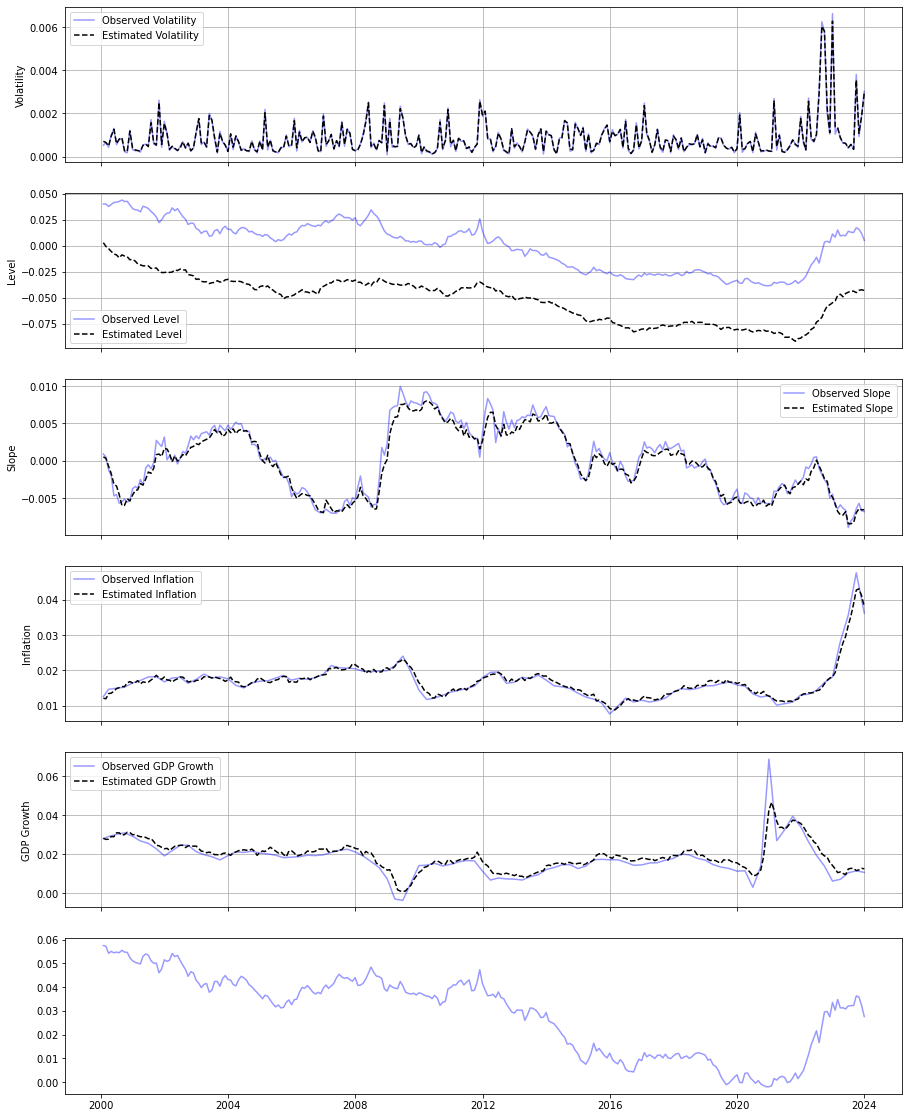

In [229]:
observations_cut = observations

# Define maturities and steps per year
maturities = np.arange(1, 11)  # Example maturities from 1 to 10 years
steps_per_year = 12  # Monthly steps

K_tilde_estimated = K_estimated_constraint + Sigma_estimated_mean @ lambda_1_estimated_constraint
Theta_tilde_estimated = np.linalg.inv(K_tilde_estimated) @ (K_estimated_constraint @ Theta_estimated_constraint - Sigma_estimated_mean @ lambda_0_estimated_mean)

A_tau_estimated, B_tau_estimated = solve_odes(maturities, steps_per_year, K_tilde_estimated, Theta_tilde_estimated, Sigma_estimated_mean, alpha, beta, delta_0_estimated_mean, delta_1_init)
A_M_estimated, B_M_estimated = compute_BM_AM(maturities[tau-1], K_estimated_constraint, Sigma_M_estimated, Theta_estimated_constraint)

points = MerweScaledSigmaPoints(n=5, alpha=0.2, beta=1.5, kappa=1)
ukf = UKF(dim_x=5, dim_z=observations_cut.shape[1], fx=lambda x, dt: state_transition_function(x, dt, K_estimated_constraint, Theta_estimated_constraint, Sigma_estimated_mean),
            hx=lambda x: measurement_function(x, A_tau_estimated, B_tau_estimated, observations_cut, A_M_estimated, B_M_estimated, Sigma_estimated_mean), dt=dt, points=points)

# initial_level = 0.04
# initial_slope = 0.001
init_pi = GDP_monthly.values[0]
init_mu = HICP_monthly.values[0]

# Initial state and covariance
X0 = np.array([EA_vol_std__.values[0], level.values[0],  slope.values[0], init_mu, init_pi])

# initial_level_var = 0.0005480207963663772
# initial_slope_var = 2.1097543572868867e-05

P0 = np.eye(5) * [np.var(EA_vol_std__.values), np.var(level.values), np.var(slope.values), np.var(HICP_monthly.values), np.var(GDP_monthly.values)]

#R = np.eye(observations_cut.shape[1]) * [np.var(EA_10Y_mth_yields__.values), np.var(EA_vol_std__.values), np.var(HICP_monthly.values), np.var(GDP_monthly.values)]  # Adjusted to match observation dimensions
R = np.eye(observations_cut.shape[1]) * [np.var(EA_vol_std__.values), np.var(level.values), np.var(slope.values), np.var(HICP_monthly.values), np.var(GDP_monthly.values), np.var(EA_10Y_mth_yields__.values)]  # Adjusted to match observation dimensions  

ukf.x = X0
ukf.P = P0
ukf.R = R
#ukf.Q = np.eye(5) * 0.0001
# print(f"Initial P0: {ukf.P}")  # Debugging print

estimated_states = []
# print("Initial State:", ukf.x)

for z in observations:
    #print(f"Observation shape before update: {z.shape}")
    Q = Q_matrix_5D(ukf.x, dt, K_estimated_constraint, Theta_estimated_constraint, Sigma_estimated_mean)
    ukf.Q = Q
    #print("Q : ", Q)
    ukf.predict()
    try:
        ukf.update(z)
        #print("Updated State:", ukf.x)
    except np.linalg.LinAlgError as e:
        print(f"LinAlgError during UKF update: {e}")
        print(f"Covariance matrix P: {ukf.P}")
    except ValueError as e:
        print(f"ValueError during UKF update: {e}")
        print(f"Observation: {z}")  # Debugging print
        print(f"Observation shape: {z.shape}")  # Debugging print

    estimated_states.append(ukf.x)

estimated_states = np.array(estimated_states)

# Ensure the dates array matches the length of the observations
dates_yields_truncated = dates_yields[:observations_cut.shape[0]]

# plt.figure(figsize=(15, 10))
# obplt = plt.plot(dates_yields_truncated, observations_cut, alpha=0.5, label=f'Observed')
# esplt = plt.plot(dates_yields_truncated, estimated_states, '--', label=f'Estimated Proxy')
# #plt.legend()
# #plt.legend(iter(obplt), ('Observed yield', 'Observed v', 'Observed pi', 'Observed mu'))
# plt.legend(iter(esplt), ('Estimated Proxy v', 'Estimated Proxy l', 'Estimated Proxy s', 'Estimated Proxy pi', 'Estimated Proxy mu'))

# Define the factor names for labeling
factors = ['Volatility', 'Level', 'Slope', 'Inflation', 'GDP Growth', '10Y Yield']

# Create subplots for each factor
fig, axes = plt.subplots(len(factors), 1, figsize=(15, 20), sharex=True)

for i, factor in enumerate(factors):
    axes[i].plot(dates_yields_truncated, observations_cut[:, i], color="b", label=f'Observed {factor}', alpha=0.4)
    axes[i].plot(dates_yields_truncated, estimated_states[:, i], color='black', ls='--', alpha=1, label=f'Estimated {factor}')
    axes[i].set_ylabel(factor)
    axes[i].legend()
    axes[i].grid(True)

# # Calculate error metrics
# mse = np.mean((estimated_states[:, :] - observations) ** 2, axis=0)
# rmse = np.sqrt(mse)
# print(f'MSE: {mse}')
# print(f'RMSE: {rmse}')

axes[-1].set_xlabel('Date')
plt.suptitle('Observed vs. Estimated Factors Over Time', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Calculate error metrics
# mse = np.mean((estimated_states - observations[0:observations_cut.shape[1] - 1]) ** 2, axis=0)
# rmse = np.sqrt(mse)
# for idx, factor in enumerate(factors):
#     print(f'{factor} - MSE: {mse[idx]}, RMSE: {rmse[idx]}')

In [ ]:
# import unittest

# def state_transition_function(x, dt, K, Theta, Sigma):
#     F = scipy.linalg.expm(-K * dt)
#     C = (np.eye(len(F)) - F) @ Theta
#     epsilon_t = [
#         Theta[0] * Sigma[0, 0]**2 / (2 * K[0, 0]) * ((1 - np.exp(-K[0, 0] * dt))**2) +
#         Sigma[0, 0]**2 / K[0, 0] * ((np.exp(-K[0, 0] * dt) - np.exp(-2 * K[0, 0] * dt))**2) * x[0],
        
#         Theta[1] * Sigma[1, 1]**2 / (2 * K[1, 1]) * ((1 - np.exp(-K[1, 1] * dt))**2) +
#         Sigma[1, 1]**2 / K[1, 1] * ((np.exp(-K[1, 1] * dt) - np.exp(-2 * K[1, 1] * dt))**2) * x[0],
        
#         Theta[2] * Sigma[2, 2]**2 / (2 * K[2, 2]) * ((1 - np.exp(-K[2, 2] * dt))**2) +
#         Sigma[2, 2]**2 / K[2, 2] * ((np.exp(-K[2, 2] * dt) - np.exp(-2 * K[2, 2] * dt))**2) * x[0],
        
#         Sigma[3, 3]**2 / (2 * K[3, 3]) * (1 - np.exp(-2 * K[3, 3] * dt)),
        
#         Sigma[4, 4]**2 / (2 * K[4, 4]) * (1 - np.exp(-2 * K[4, 4] * dt))
#     ]
#     e_t = np.random.normal(0, np.abs(epsilon_t))
#     transition = C + F @ x + e_t
#     return transition

# class TestStateTransitionFunction(unittest.TestCase):
#     def test_state_transition_function(self):
#         x = X0
#         dt = 1/12
#         K = K_init
#         Theta = Theta_init
#         Sigma = Sigma_init
        
#         output = state_transition_function(x, dt, K, Theta, Sigma)
        
#         # Normalize the output and expected values
#         expected_mean = np.array([1, 2, 3, 4, 5])
#         output_normalized = (output - np.mean(output)) / np.std(output)
#         expected_normalized = (expected_mean - np.mean(expected_mean)) / np.std(expected_mean)
        
#         # Check if the normalized output is within a reasonable range of the normalized expected values
#         tolerance = 0.1 # Adjust tolerance as needed
        
#         for i in range(len(output_normalized)):
#             self.assertAlmostEqual(output_normalized[i], expected_normalized[i], delta=tolerance)

# # Run the tests
# unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestStateTransitionFunction))

In [ ]:
output = state_transition_function(X0, dt, K_init, Theta_init, Sigma_init)
output

(6336, 4)
(6336, 5)


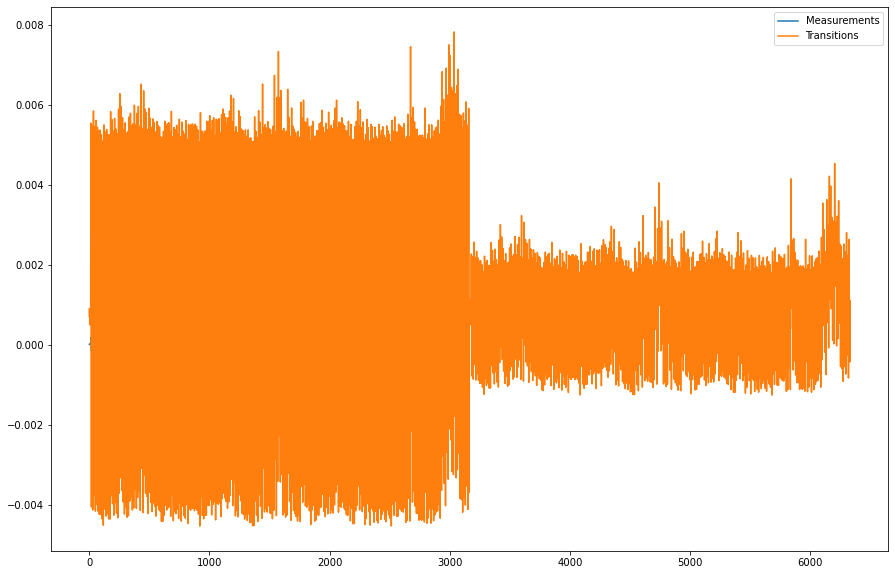

In [66]:
unique_measurements = np.array(unique_measurements)
unique_transitions = np.array(unique_transitions)
print(unique_measurements.shape)
print(unique_transitions.shape)

# # Create x-axes for both datasets
# x2 = np.linspace(0, 1, len(observations_cut))
# x1 = np.linspace(0, 1, len(unique_measurements))
# obs_int = np.interp(x1, x2, observations_cut[:,1])

plt.figure(figsize=(15, 10))
# plt.plot(obs_int, alpha=0.3, label=f'Observed')
plt.plot(unique_measurements[:3000,1], label=f'Measurements')
plt.plot(unique_transitions[:,0], label=f'Transitions')
plt.legend()

In [ ]:
plt.figure(figsize=(15, 10))
every_11th_element = unique_measurements[::11]
plt.plot(every_11th_element, label=f'Measurements')
plt.plot(observations_cut, alpha=0.3, label=f'Observed')

In [ ]:
print(unique_measurements)


In [95]:
%store estimated_states
print(estimated_states)
print(X0)

Stored 'estimated_states' (ndarray)
[[ 0.00068618  0.03395612  0.0007686   0.01170392  0.02809985]
 [ 0.0006075   0.03346981  0.00047245  0.01161486  0.0275954 ]
 [ 0.00098075  0.03568769 -0.00026456  0.0133662   0.02803281]
 ...
 [ 0.00063164  0.00657464 -0.00647139  0.04424206  0.01173743]
 [ 0.00105006  0.00624325 -0.00669702  0.04557036  0.01153522]
 [ 0.00162185  0.00672327 -0.00656448  0.03990445  0.01187563]]
[0.00064057 0.04026058 0.0009015  0.0115     0.02779365]


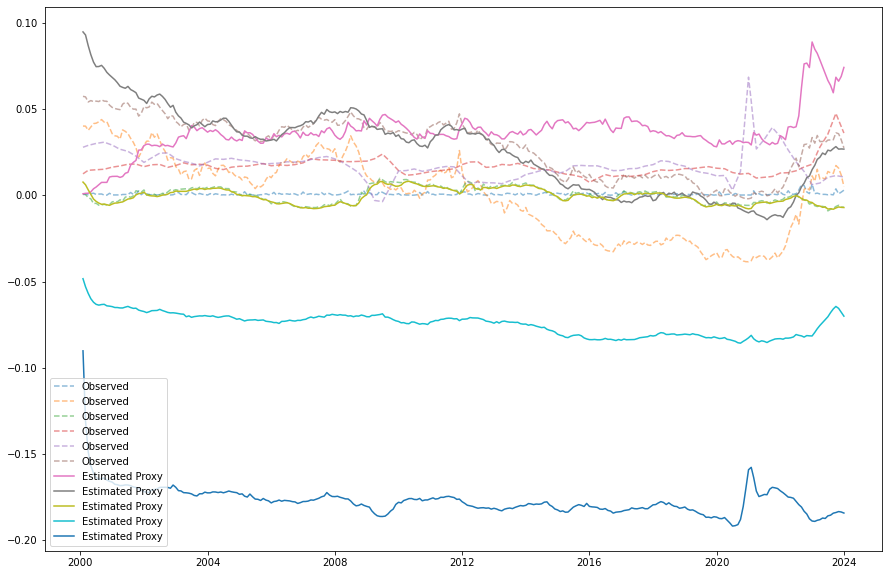

In [201]:
plt.figure(figsize=(15, 10))
obplt = plt.plot(dates_yields_truncated, observations_cut, label=f'Observed', alpha=0.5, linestyle='--')
esplt = plt.plot(dates_yields_truncated, estimated_states, label=f'Estimated Proxy')
#plt.legend(iter(obplt), ('Observed yield', 'Observed v', 'Observed pi', 'Observed mu'))
# plt.legend(iter(esplt), ('Estimated Proxy v', 'Estimated Proxy l', 'Estimated Proxy s', 'Estimated Proxy pi', 'Estimated Proxy mu'))
plt.legend()

In [96]:
%store -r mean_paths

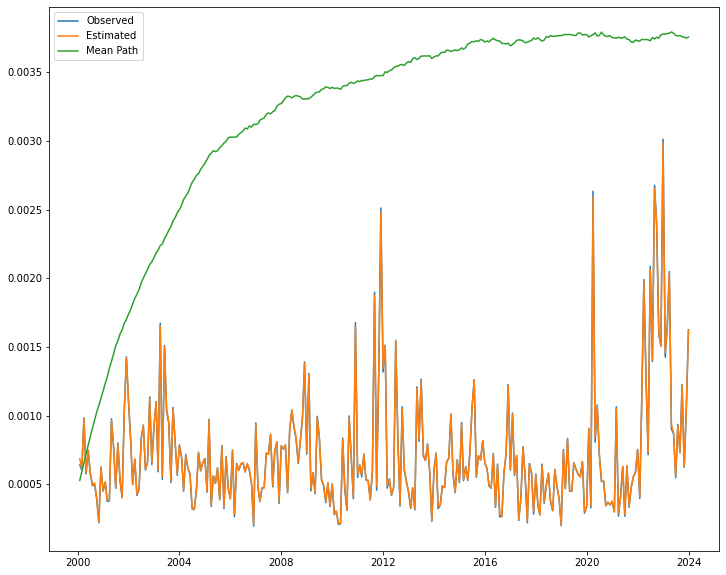

In [99]:
plt.figure(figsize=(12, 10))
#plt.yscale('symlog')
obplt = plt.plot(dates_yields_truncated, observations_cut[:,0], label=f'Observed')
esplt = plt.plot(dates_yields_truncated, estimated_states[:,0], label=f'Estimated')
plt.plot(dates_yields_truncated, mean_paths[:288,0], label=f'Mean Path')
plt.legend()

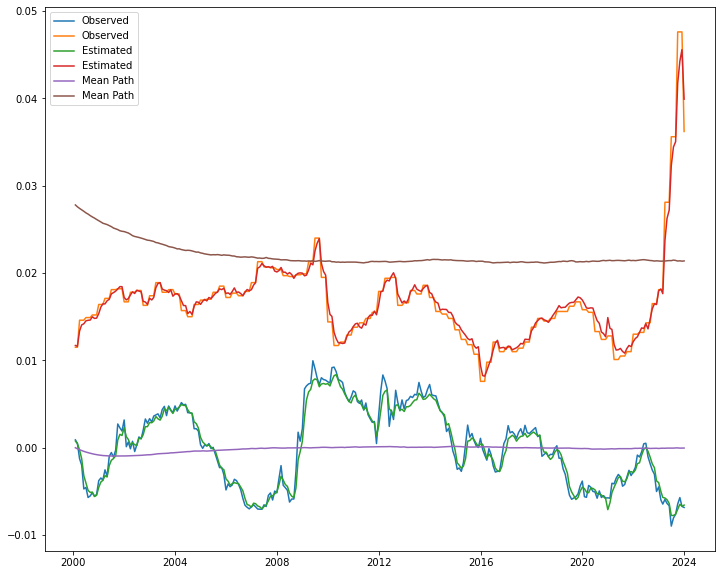

In [100]:
plt.figure(figsize=(12, 10))
#plt.yscale('symlog')
obplt = plt.plot(dates_yields_truncated, observations_cut[:,2:4], label=f'Observed')
esplt = plt.plot(dates_yields_truncated, estimated_states[:,2:4], label=f'Estimated')
plt.plot(dates_yields_truncated, mean_paths[:288,2:4], label=f'Mean Path')
plt.legend()

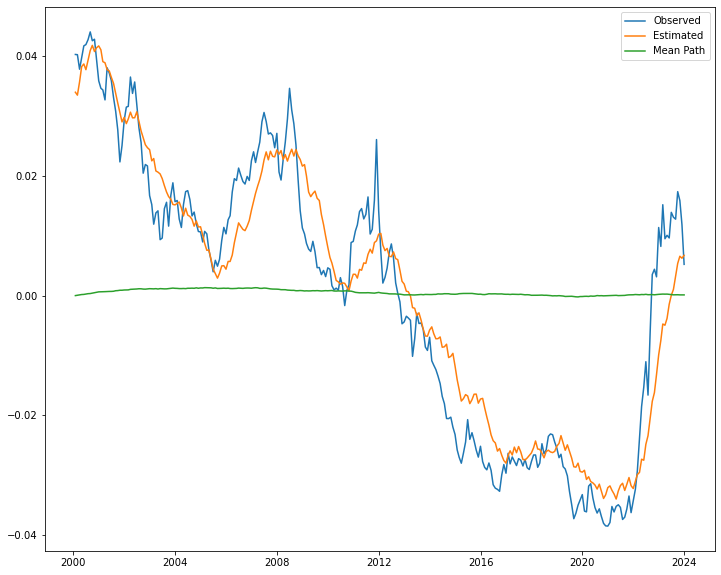

In [103]:
plt.figure(figsize=(12, 10))
#plt.yscale('symlog')
obplt = plt.plot(dates_yields_truncated, observations_cut[:,1], label=f'Observed')
esplt = plt.plot(dates_yields_truncated, estimated_states[:,1], label=f'Estimated')
plt.plot(dates_yields_truncated, mean_paths[:288,1], label=f'Mean Path')
plt.legend()


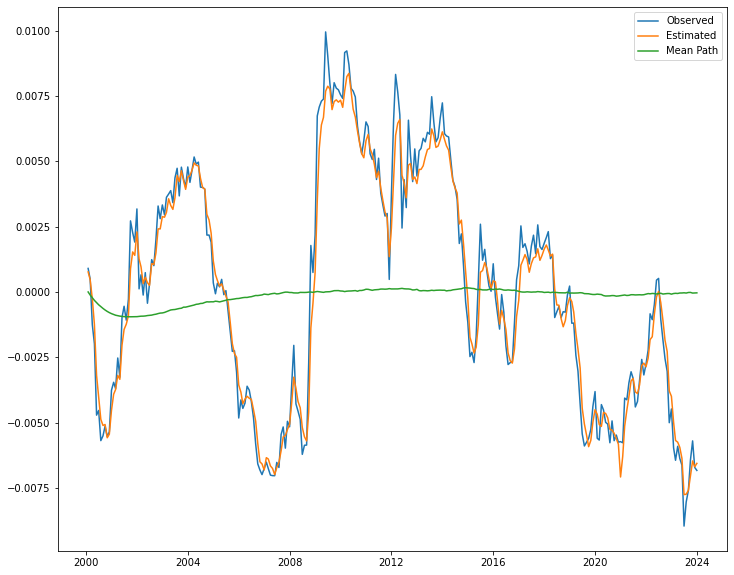

In [104]:
plt.figure(figsize=(12, 10))
#plt.yscale('symlog')
obplt = plt.plot(dates_yields_truncated, observations_cut[:,2], label=f'Observed')
esplt = plt.plot(dates_yields_truncated, estimated_states[:,2], label=f'Estimated')
plt.plot(dates_yields_truncated, mean_paths[:288,2], label=f'Mean Path')
plt.legend()